# Retail Transaction Data Analysis - Supervised Learning

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from matplotlib.ticker import MaxNLocator
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 6)
matplotlib.rcParams.update({'font.size': 15})
import matplotlib.pyplot as plt
import seaborn as sns

## 1 Supervised learning

Here, you are going to use the features you generated in Assignment #3 to predict the clients response to a promotion campaign. This is a typical classiﬁcation problem in the retail industry, but the formulation of the problem is similar to industries such as fraud detection, marketing and manufacturing.

The clients responses are stored in the Retail Data Response.csv ﬁle from Kaggle. The responses are **binary**: **0** for clients who responded negatively to the promotional campaign and **1** for clients who responded positively to the campaign.

You will explore solving the classiﬁcation problem with two diﬀerent sets of features (i.e. annual and monthly) and three diﬀerent algorithms as shown in the image below.

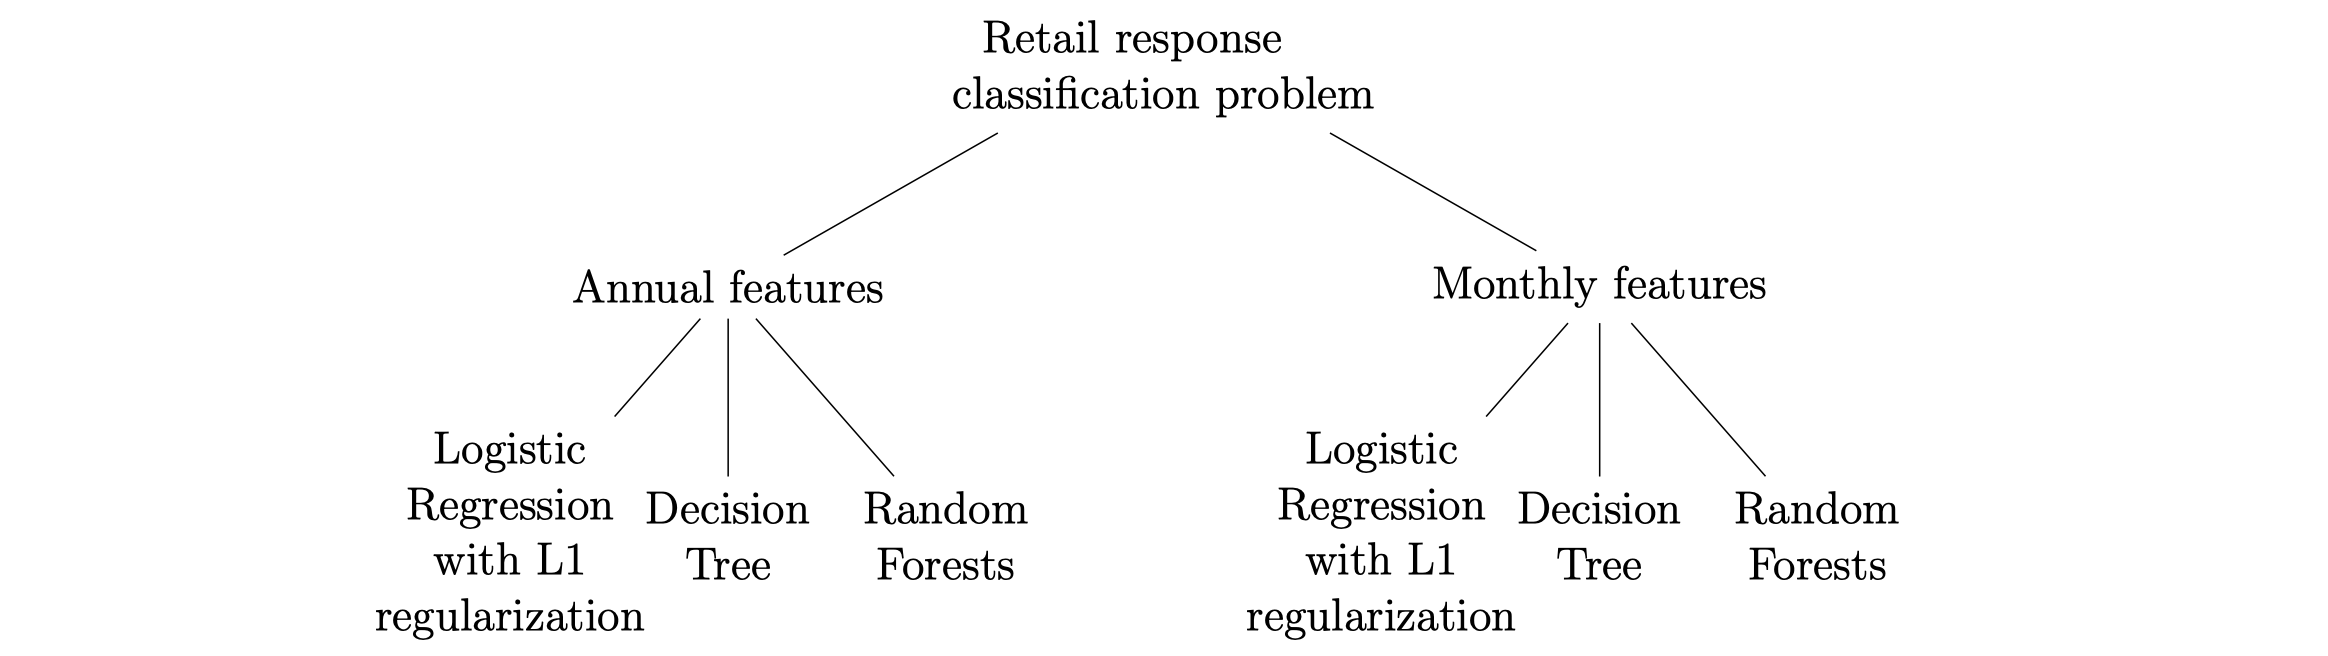

### 1.1 Import the monthly and annual data and join

In Assignment #3, you created ﬁve diﬀerent feature families that capture annual and monthly aggregations. Here, you will model the retail problem with two approaches: using annual and monthly features. Therefore, you need to create the joined tables based on the following logic:

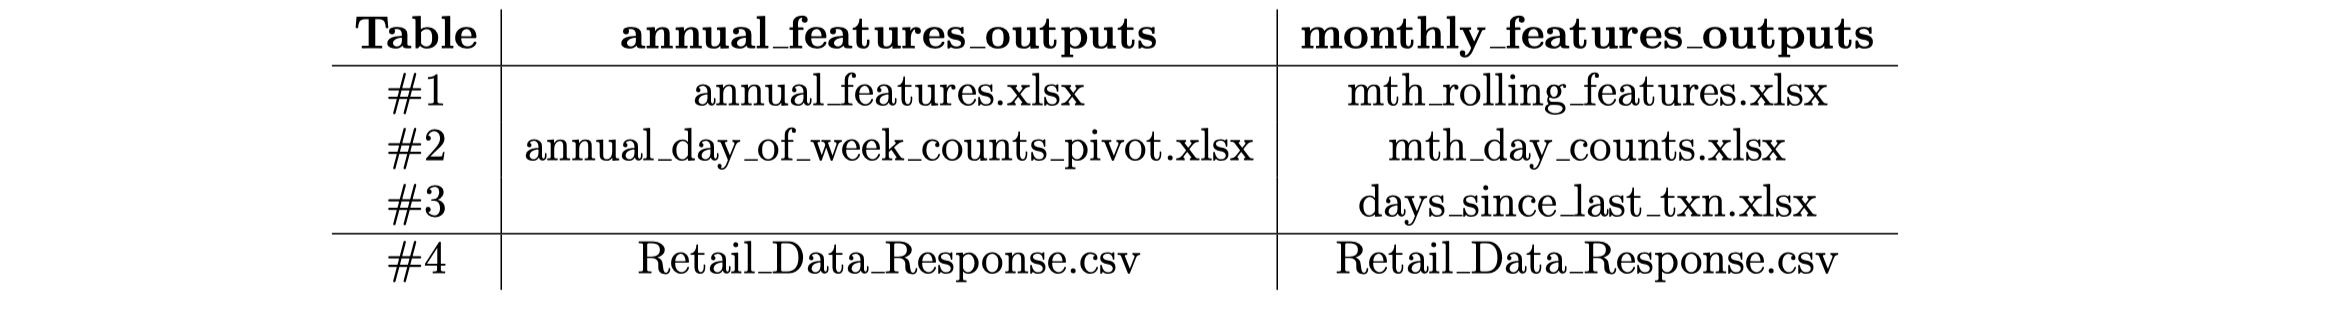

In both the annual and monthly features approach, you need to join at the end with table #4, the clients responses. This is simply a table that contains the binary response of the client to our marketing eﬀort as described above and that is the **output** or **label** or **target** that makes this a supervised learning problem.

In [2]:
retail_data_response = pd.read_csv('Retail_Data_Response.csv')
print(retail_data_response.shape)
retail_data_response.head()

(6884, 2)


,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


#### Join annual features at the end with table #4 (retail_data_response)

In [3]:
annual_features = pd.read_excel('annual_features.xlsx')
print(annual_features.shape)
annual_features.head(1)

(6889, 41)


,customer_id,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_max_2011,ann_txn_amt_max_2012,ann_txn_amt_max_2013,ann_txn_amt_max_2014,...,ann_txn_amt_var_2011,ann_txn_amt_var_2012,ann_txn_amt_var_2013,ann_txn_amt_var_2014,ann_txn_amt_var_2015,ann_txn_cnt_2011,ann_txn_cnt_2012,ann_txn_cnt_2013,ann_txn_cnt_2014,ann_txn_cnt_2015
0,CS1112,70.666667,67.4,70.666667,70.666667,39.0,96,81,105,90,...,485.333333,161.8,1190.333333,284.333333,0.0,3,5,3,3,1


In [4]:
annual_day_of_week_counts_pivot = pd.read_excel('annual_day_of_week_counts_pivot.xlsx')
print(annual_day_of_week_counts_pivot.shape)
annual_day_of_week_counts_pivot.head(1)

(6889, 36)


,customer_id,cnt_2011_Friday,cnt_2011_Monday,cnt_2011_Saturday,cnt_2011_Sunday,cnt_2011_Thursday,cnt_2011_Tuesday,cnt_2011_Wednesday,cnt_2012_Friday,cnt_2012_Monday,...,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday
0,CS1112,1,0,0,1,0,0,1,0,0,...,1,1,1,0,0,0,0,0,0,1


In [5]:
annual_features_outputs = annual_features.merge(annual_day_of_week_counts_pivot, how='left', on=['customer_id'])
annual_features_outputs = retail_data_response.merge(annual_features_outputs, how='left', on=['customer_id'])
annual_features_outputs

,customer_id,response,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_max_2011,ann_txn_amt_max_2012,ann_txn_amt_max_2013,...,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday
0,CS1112,0,70.666667,67.400000,70.666667,70.666667,39.000000,96,81,105,...,1,1,1,0,0,0,0,0,0,1
1,CS1113,0,81.333333,74.800000,85.200000,56.500000,73.333333,94,95,97,...,0,3,0,0,2,0,0,0,0,1
2,CS1114,1,85.200000,75.000000,70.400000,70.833333,79.000000,97,97,105,...,0,1,1,0,0,0,0,1,0,0
3,CS1115,1,87.000000,67.571429,79.571429,78.250000,55.000000,102,104,94,...,2,0,2,0,0,0,0,1,0,0
4,CS1116,1,58.750000,76.666667,59.000000,66.600000,0.000000,87,105,59,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6879,CS8996,0,31.000000,33.666667,41.500000,56.000000,0.000000,38,38,50,...,1,1,2,0,0,0,0,0,0,0
6880,CS8997,0,45.000000,39.500000,35.166667,42.000000,0.000000,47,49,75,...,0,0,0,0,0,0,0,0,0,0
6881,CS8998,0,64.000000,54.400000,47.000000,32.500000,0.000000,69,79,75,...,0,1,1,0,0,0,0,0,0,0
6882,CS8999,0,52.000000,25.250000,28.000000,21.000000,0.000000,64,30,39,...,0,0,2,0,0,0,0,0,0,0


In [6]:
# export to excel file
#annual_features_outputs.to_excel('annual_features_outputs.xlsx')

#### Join monthly features at the end with table #4 (retail_data_response)

In [7]:
mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')
print(mth_rolling_features.shape)
mth_rolling_features.head(1)

(323783, 23)


,Unnamed: 0,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,...,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M
0,157064,CS1112,2011-05-31,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
mth_day_counts = pd.read_excel('mth_day_counts.xlsx')
print(mth_day_counts.shape)
mth_day_counts.head(1)

(323783, 10)


,Unnamed: 0,CLNT_NO,ME_DT,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday
0,0,CS5295,2013-02-28,0,1,0,0,0,0,0


In [9]:
days_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')
print(days_since_last_txn.shape)
days_since_last_txn.head(1)

(323783, 4)


,Unnamed: 0,CLNT_NO,ME_DT,days_since_last_txn
0,157064,CS1112,2011-05-31,0


In [10]:
# rename retail_data_response column name to match for monthly feature tables
retail_data_response_mth = retail_data_response.rename(columns={"customer_id": "CLNT_NO"})

# join monthly features at the end with table #4 (retail_data_response)
monthly_features_outputs = mth_day_counts.merge(days_since_last_txn, how='left', on=['CLNT_NO', 'ME_DT'])
monthly_features_outputs = mth_rolling_features.merge(monthly_features_outputs, how='left', on=['CLNT_NO', 'ME_DT'])
monthly_features_outputs = retail_data_response_mth.merge(monthly_features_outputs, how='left', on=['CLNT_NO'])
monthly_features_outputs.drop(['Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0'], inplace = True, axis = 1)
monthly_features_outputs

,CLNT_NO,response,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,...,txn_cnt_mean_12M,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn
0,CS1112,0,2011-05-31,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
1,CS1112,0,2011-06-30,56,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,1,15
2,CS1112,0,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,...,NaN,NaN,0,0,0,0,0,0,0,46
3,CS1112,0,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,...,NaN,NaN,1,0,0,0,0,0,0,12
4,CS1112,0,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,...,NaN,NaN,0,0,0,0,0,0,0,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,CS9000,0,2014-11-30,0,0,0.0,0.000000,0.0,0.0,0.000000,...,0.333333,1.0,0,0,0,0,0,0,0,98
323544,CS9000,0,2014-12-31,0,0,0.0,0.000000,0.0,0.0,0.000000,...,0.333333,1.0,0,0,0,0,0,0,0,129
323545,CS9000,0,2015-01-31,0,0,0.0,0.000000,0.0,0.0,0.000000,...,0.250000,1.0,0,0,0,0,0,0,0,160
323546,CS9000,0,2015-02-28,34,1,34.0,11.333333,34.0,1.0,0.333333,...,0.333333,1.0,0,0,1,0,0,0,0,0


In [11]:
# export to excel file
#monthly_features_outputs.to_excel('monthly_features_outputs.xlsx')

In [12]:
#annual_features_outputs['response'].isnull().sum()
#print(annual_features_outputs['response'].isnull().sum())

### 1.2 Steps for each method (10 points)

In [13]:
# read excel files
#annual_features_outputs = pd.read_excel('annual_features_outputs.xlsx')
#monthly_features_outputs = pd.read_excel('monthly_features_outputs.xlsx')

### 1) Annual Features

1. Separate the inputs **X** and the output **y** in two data frames.

In [14]:
X_annual = annual_features_outputs.drop(['response', 'customer_id'], axis = 1)
y_annual = annual_features_outputs['response']

In [15]:
y_annual.value_counts()

0    6237
1     647
Name: response, dtype: int64

2. Split the data in train and test set. Use a test size value of 2/3 and set the random state equal to 1147 for consistency (i.e. the course code value). Use the following names for consistency.

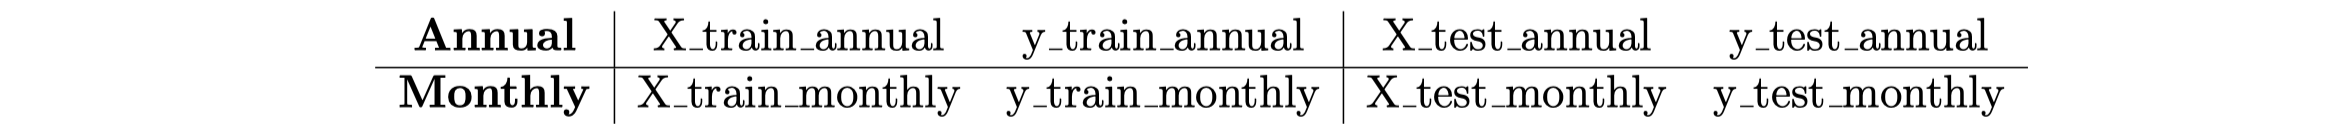

In [16]:
# Split in train and test sets
X_train_annual, X_test_annual, y_train_annual, y_test_annual = train_test_split(X_annual, y_annual, 
                                                                                test_size=2/3, 
                                                                                random_state=1147)

3. Pre-process (if necessary for the method).

In [17]:
# Create the instance of the scaler
scaler = StandardScaler()

# Transform the inputs X
X_train_annual_scaled = scaler.fit_transform(X_train_annual)
X_test_annual_scaled = scaler.transform(X_test_annual)

X_train_annual_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

####  Annual Features: L1 log-reg

4. Fit the training dataset and optimize the hyperparameters of the method.

In [18]:
def lr_tune_param_plot(C, opt_i, X, X_train_scaled, X_test_scaled, y_train, y_test):
    # Smaller C values, stronger regularization, more coefficients will go to zero
    
    # Initialize the variables you want to save in an iterative manner
    count                     = -1
    Train_AUC_iter_LR         = np.zeros(shape=(len(C),1))
    Test_AUC_iter_LR          = np.zeros(shape=(len(C),1))
    NonZeroCoeff_LR           = np.zeros(shape=(len(C),1))
    Model_Coeff_LR            = np.zeros(shape=(X.shape[1], len(C)))

    fig = plt.figure(figsize=(16, 16))

    for c in C:
        count += 1
        # instantiate a logistic regression model, and fit with X and y
        model_LR = LogisticRegression(C=c, penalty='l1', solver='liblinear', class_weight='balanced')
        # Fit the model
        model_LR.fit(X_train_scaled, y_train)
        Model_Coeff_LR[:,count] = model_LR.coef_[0,:]
        # Scores for train set
        scores_train_LR = model_LR.predict_proba(X_train_scaled)[:, 1]
        # Scores for test set
        scores_test_LR = model_LR.predict_proba(X_test_scaled)[:, 1]

        # ============================ #
        # === [Train: ROC and AUC] === #
        # ============================ #
        # ROC Calc
        fpr_train_LR, tpr_train_LR, _ = roc_curve(y_train, scores_train_LR)
        # AUC Calc
        auc_train_LR = auc(fpr_train_LR, tpr_train_LR)
        Train_AUC_iter_LR[count,0] = auc_train_LR
        # ============================ #
        # === [Test: ROC and AUC] === #
        # ============================ #
        # ROC Calc
        fpr_test_LR, tpr_test_LR, _ = roc_curve(y_test, scores_test_LR)
        # AUC Calc
        auc_test_LR = auc(fpr_test_LR, tpr_test_LR)
        Test_AUC_iter_LR[count,0] = auc_test_LR
        ### Extract the count of non-zero coefficients
        NonZeroCoeff_LR[count,0] = X.shape[1] - (model_LR.coef_ == 0).sum()

        x = model_LR.coef_.transpose()   
        index = np.arange(len(x))  

        ax = fig.add_subplot(6,5,count+1)
        ax.scatter(index, x)
        ax.set_title('C=%.3f, NZ:%s' %(c,X.shape[1]-(model_LR.coef_ == 0).sum()))
        ax.set_xlabel('Feature index', fontsize = 14)
        ax.set_ylabel('Feature coefficient', fontsize = 14)
    plt.tight_layout()
    plt.show()
    
    
    # Plot of the NonZero coefficients    
    fig = plt.figure(figsize=(16, 8))
    sub1 = fig.add_subplot(121)
    plt.scatter(C, NonZeroCoeff_LR)
    sub1.set_ylabel('Number of Non-Zero coefficients')
    sub1.set_xlabel('C value (inverse of alpha)')
    sub1.yaxis.set_major_locator(MaxNLocator(integer=True))
    # sub1.set_xlim(0.01,1)
    # plt.xscale('log')
    # plt.show()

    sub2 = fig.add_subplot(122)
    plt.scatter(C,Train_AUC_iter_LR)
    plt.scatter(C,Test_AUC_iter_LR)
    sub2.set_xlabel('C value (inverse of alpha)')
    sub2.set_ylabel('Train/Test set|AUC')
    # sub1.set_xlim(0.02,0.06)
    plt.annotate('AUC= %0.3f' %(Test_AUC_iter_LR[opt_i]), xy=(C[opt_i], 1.003*Test_AUC_iter_LR[opt_i]), xycoords='data',horizontalalignment= 'left', fontsize = 12)
    plt.annotate('AUC= %0.3f' %(Train_AUC_iter_LR[opt_i]), xy=(0.9*C[opt_i], 1.003*Train_AUC_iter_LR[opt_i]), xycoords='data',horizontalalignment= 'right', fontsize = 12)
    plt.legend(['Train','Test'], loc ='lower right')
    plt.axhline(Test_AUC_iter_LR[opt_i], color = 'k', linestyle = '--')
    plt.axvline(C[opt_i], color = 'k', linestyle = '--')
    # plt.plot([C[8],C[8]],[plt.ylim()[0],Test_AUC_iter_LR[8]])
    # plt.xscale('log')

    plt.show()

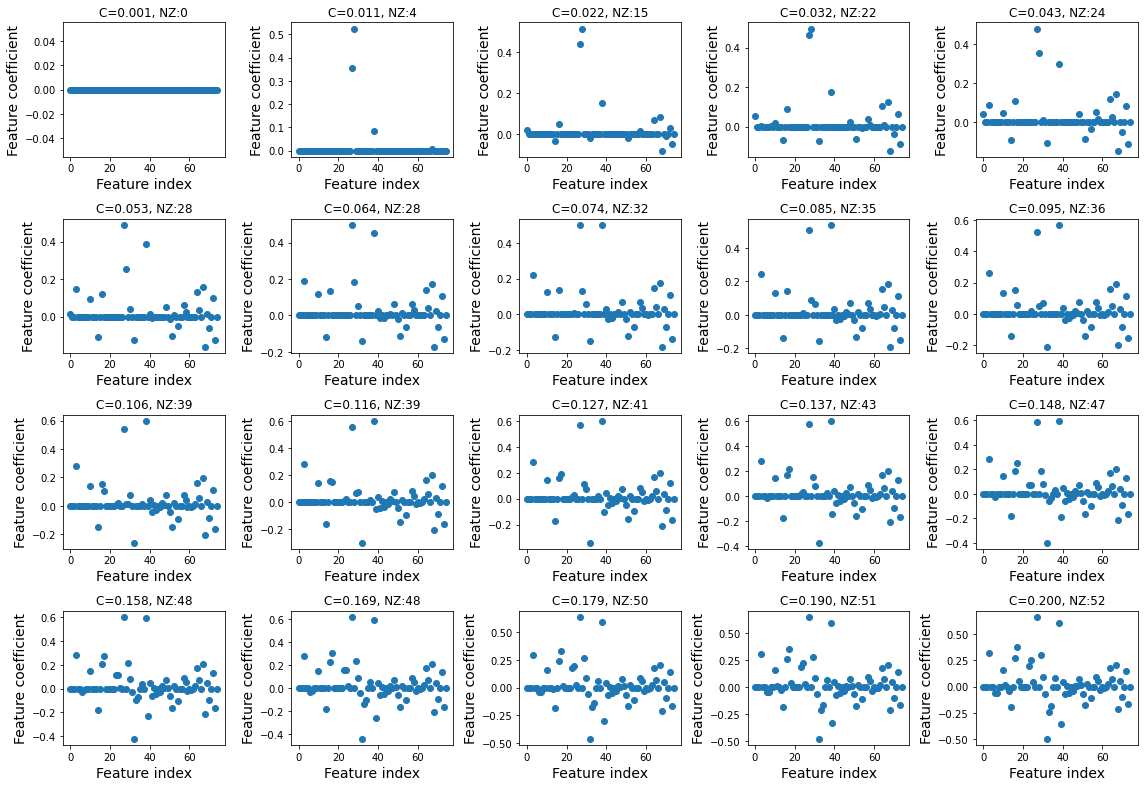

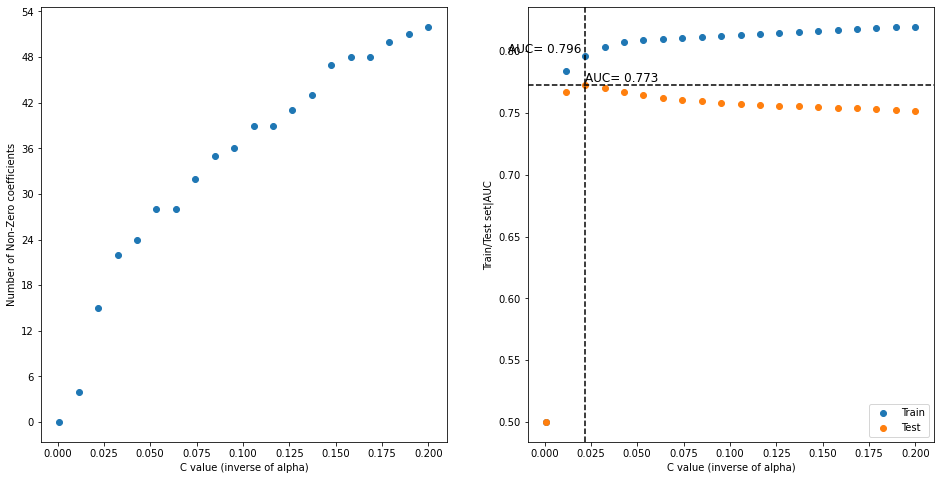

In [19]:
#np.linspace(0.001, 1, 25)
#np.linspace(0.001, 0.8, 20)
#np.linspace(0.001, 0.1, 20) 14
C = np.linspace(0.001, 0.2, 20)
lr_tune_param_plot(C, 2, X_annual, X_train_annual_scaled, X_test_annual_scaled, y_train_annual, y_test_annual)

*Choose the 3th (index 2) value of C = 0.022 to be the best hyperparameter since after which the AUC for test set starts declining, meaning worse performance.*

In [20]:
estimator = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=C[2])
LogReg = estimator.fit(X_train_annual_scaled, y_train_annual)

5. Plot coeﬃcient values or feature importance.

In [21]:
#m_annual = LogReg.coef_[0]
#b_annual = LogReg.intercept_
importances = LogReg.coef_[0]

In [22]:
def plot_feature_importance(X_data, importances):
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Rearrange feature names so they match the sorted feature importances
    names = [X_data.columns[i] for i in indices]

    # Create plot
    plt.figure(figsize=(15,6))
    # Create plot title
    plt.title("Coefficient values/Feature importance", fontsize = 18)
    # Add bars
    plt.bar(range(X_data.shape[1]), importances[indices])
    # Add feature names as x-axis labels
    plt.xticks(range(X_data.shape[1]), names, rotation=90, fontsize = 13)
    # Show plot
    plt.show()

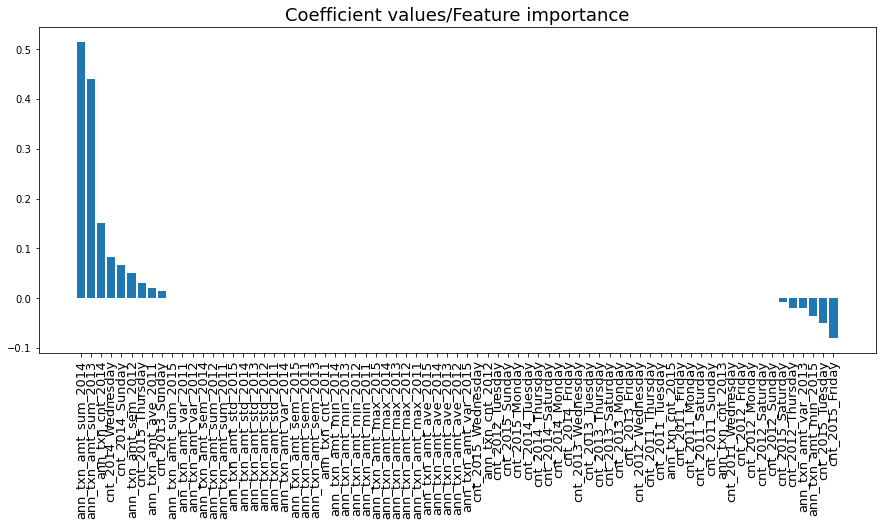

In [23]:
plot_feature_importance(X_annual, importances)

6. Plot probability distribution for test set.

In [24]:
y_test_annual_proba = LogReg.predict_proba(X_test_annual_scaled)
y_test_annual_proba

array([[0.75558537, 0.24441463],
       [0.55155977, 0.44844023],
       [0.42756381, 0.57243619],
       ...,
       [0.61391242, 0.38608758],
       [0.77346299, 0.22653701],
       [0.06749532, 0.93250468]])

In [25]:
def plot_prob_dist(y_test_proba):
    plt.figure(figsize=(10,5))
    #sns.displot(data = y_test_proba[:,1], x = 100*y_test_proba[:,1])
    plt.hist(y_test_proba[:,1], bins=100)
    plt.title('Distribution of probabilities to positive response')
    plt.xlabel('Probability to positive response (%)')
    plt.ylabel('Counts of clients')

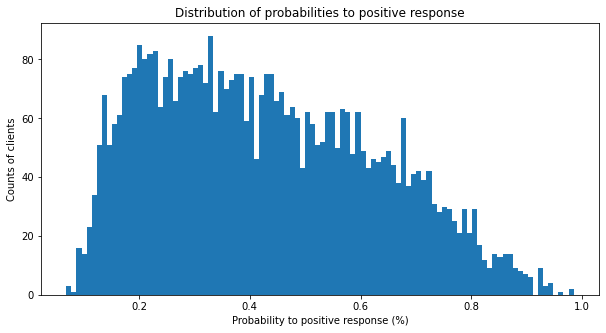

In [26]:
plot_prob_dist(y_test_annual_proba)

7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

##### Train set

In [27]:
y_train_annual_predicted = LogReg.predict(X_train_annual_scaled)
print(y_train_annual_predicted)

[1 1 0 ... 1 0 0]


In [28]:
cm = confusion_matrix(y_train_annual, y_train_annual_predicted)
print(cm)

[[1451  647]
 [  44  152]]


In [29]:
def plot_cm(cm, datatype):
    plt.clf()
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    classNames = ['Negative Response','Positive Responose']
    plt.title('Negative or Positive Response Confusion Matrix - ' + datatype + ' Data', fontsize=18)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classNames, fontsize=15)
    s = [['TN','FP'], ['FN', 'TP']]
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 18,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.show()

<Figure size 432x288 with 0 Axes>

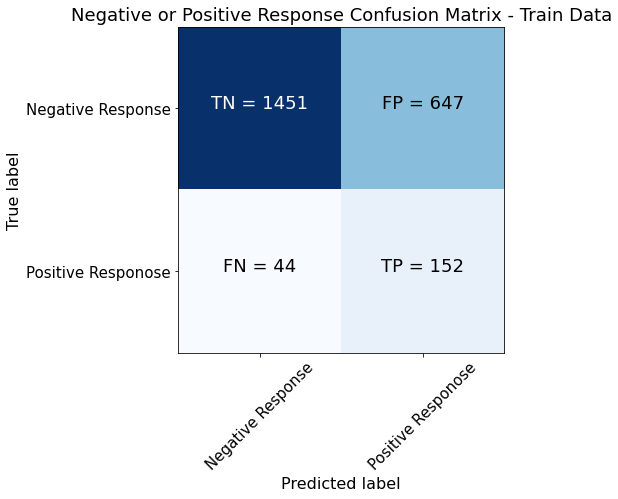

In [30]:
plot_cm(cm, 'Train')

In [31]:
def metrics(datatype, y, y_predicted):
    print('Classification Report (', datatype, '):\n', classification_report(y, y_predicted,
                                                                    target_names = ['Negative Response',
                                                                                    'Positive Response']))
    print('Accuracy (', datatype, '):', accuracy_score(y, y_predicted))

In [32]:
metrics('Train', y_train_annual, y_train_annual_predicted)

Classification Report ( Train ):
                    precision    recall  f1-score   support

Negative Response       0.97      0.69      0.81      2098
Positive Response       0.19      0.78      0.31       196

         accuracy                           0.70      2294
        macro avg       0.58      0.73      0.56      2294
     weighted avg       0.90      0.70      0.76      2294

Accuracy ( Train ): 0.6987794245858762


##### Test set

In [33]:
y_test_annual_predicted = LogReg.predict(X_test_annual_scaled)
print(y_test_annual_predicted)

[0 0 1 ... 0 0 1]


In [34]:
cm = confusion_matrix(y_test_annual, y_test_annual_predicted)
print(cm)

[[2835 1304]
 [ 120  331]]


<Figure size 432x288 with 0 Axes>

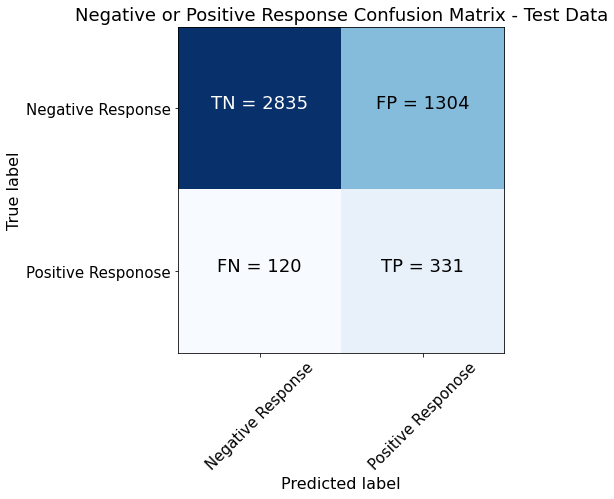

In [35]:
plot_cm(cm, 'Test')

In [36]:
metrics('Test', y_test_annual, y_test_annual_predicted)

Classification Report ( Test ):
                    precision    recall  f1-score   support

Negative Response       0.96      0.68      0.80      4139
Positive Response       0.20      0.73      0.32       451

         accuracy                           0.69      4590
        macro avg       0.58      0.71      0.56      4590
     weighted avg       0.89      0.69      0.75      4590

Accuracy ( Test ): 0.689760348583878


##### ROC

In [37]:
def plot_roc(estimator, X_train, X_test, y_train, y_test, title):
    # Scores for train set
    scores_train = estimator.predict_proba(X_train)[:, 1]
    # Scores for test set
    scores_test = estimator.predict_proba(X_test)[:, 1]

    # ROC Calc Train set
    fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
    # ROC Calc Test set
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    # AUC Calc
    auc_train = auc(fpr_train, tpr_train)
    # AUC Calc
    auc_test  = auc(fpr_test, tpr_test)

    # Plotting
    plt.figure(figsize=(8,8))
    plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
    plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
    plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
    plt.ylim([0,1.0])
    plt.xlim([0,1.0])
    plt.title(title + ' ROC curves', fontsize = 18)
    plt.ylabel('True positive rate', fontsize = 16)
    plt.xlabel('False positive rate', fontsize = 16)
    plt.legend()
    plt.show()

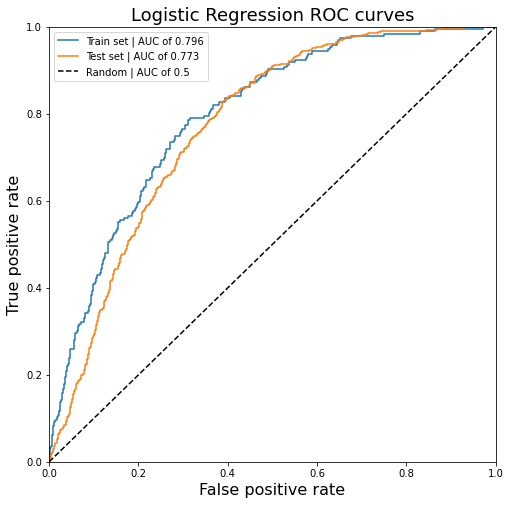

In [38]:
plot_roc(LogReg, X_train_annual_scaled, X_test_annual_scaled, y_train_annual, y_test_annual, 
         'Logistic Regression')

8. Plot decision boundary for top 2 features.

    The coefficients with the highest values are 'ann_txn_amt_sum_2013' (27th column) and 'ann_txn_amt_sum_2014' (28th column).

In [39]:
def min_max_for_grid(importances, X, X_scaled):
    
    #coef1 = np.where(X_data.columns == feat1)[0][0]
    #coef2 = np.where(X_data.columns == feat2)[0][0]
    coef1, coef2 = np.argsort(importances)[::-1][:2]
    feat1, feat2 = X.columns[coef1], X.columns[coef2]
    print('coefficient 1: ', feat1, ', index: ', coef1)
    print('coefficient 2: ', feat2, ', index: ', coef2)

    coef1_min_raw = X_scaled.min(axis=0)[coef1]
    coef1_max_raw = X_scaled.max(axis=0)[coef1]
    
    coef2_min_raw = X_scaled.min(axis=0)[coef2]
    coef2_max_raw = X_scaled.max(axis=0)[coef2]

    # round down and round up for min and max respectively
    coef1_min = np.floor(coef1_min_raw)
    coef1_max = np.ceil(coef1_max_raw)
    diff1 = coef1_max-coef1_min
    
    coef2_min = np.floor(coef2_min_raw)
    coef2_max = np.ceil(coef2_max_raw)
    diff2 = coef2_max-coef2_min
    
    print('\n--- coefficient 1 ----')
    print('min:', coef1_min_raw, '->', coef1_min)
    print('max:', coef1_max_raw, '->', coef1_max)
    print('difference:', diff1)
    
    print('\n--- coefficient 2 ----')
    print('min:', coef2_min_raw, '->', coef2_min)
    print('max:', coef2_max_raw, '->', coef2_max)
    print('difference:', diff2)
    
    return feat1, feat2, coef1, coef2, coef1_min, coef1_max, coef2_min, coef2_max

In [40]:
feat1, feat2, coef1, coef2, coef1_min, coef1_max, coef2_min, coef2_max = min_max_for_grid(importances,
                                                                                          X_annual,
                                                                                          X_train_annual_scaled)

coefficient 1:  ann_txn_amt_sum_2014 , index:  28
coefficient 2:  ann_txn_amt_sum_2013 , index:  27

--- coefficient 1 ----
min: -1.755266718463368 -> -2.0
max: 3.824668181429266 -> 4.0
difference: 6.0

--- coefficient 2 ----
min: -1.6977424959358869 -> -2.0
max: 5.53912436943854 -> 6.0
difference: 8.0


In [41]:
xx, yy = np.mgrid[coef1_min:coef1_max:0.666, coef2_min:coef2_max:0.888] # The steps were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

(100, 2)


In [42]:
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, X_train_annual.shape[1])) * np.median(X_train_annual_scaled, axis=0) 
pd.DataFrame(median_inputs)

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
1,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
2,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
3,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
4,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
96,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
97,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
98,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195


In [43]:
# Then, we replace the 27th and 28th column with the values of the grid
median_inputs[:,coef1] = grid[:,0]
median_inputs[:,coef2] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:20,:30]
df.style.apply(lambda x: ['background: grey' if (x.name == coef1)|(x.name == coef2)  else '' for i in x])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-2.000000,-2.000000,-0.218893
1,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-1.112000,-2.000000,-0.218893
2,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-0.224000,-2.000000,-0.218893
3,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,0.664000,-2.000000,-0.218893
4,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,1.552000,-2.000000,-0.218893
5,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,2.440000,-2.000000,-0.218893
6,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,3.328000,-2.000000,-0.218893
7,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,4.216000,-2.000000,-0.218893
8,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,5.104000,-2.000000,-0.218893
9,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,5.992000,-2.000000,-0.218893


In [44]:
def plot_contour(estimator, X_data, y_data, coef1_col, coef2_col):
    # Score the artificial data on the grid
    probs = estimator.predict_proba(median_inputs)[:, 1].reshape(xx.shape)
    
    # Plot the contour for the grid and a scatter of 50 original datapoints from X_train
    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X_data[50:,coef1], X_data[50:, coef2], c=y_data[50:], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(aspect="auto",
           xlim=(coef1_min, coef1_max), ylim=(coef2_min, coef2_max),
           xlabel=coef1_col, ylabel=coef2_col)

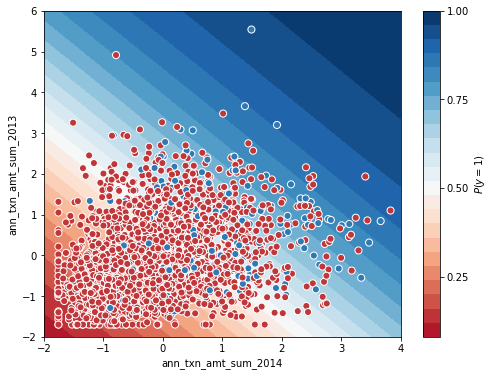

In [45]:
plot_contour(LogReg, X_train_annual_scaled, y_train_annual, feat1, feat2)

#### Annual Features: Decision Tree

4. Fit the training dataset and optimize the hyperparameters of the method.

In [46]:
def dt_tune_param(max_depth, X_train, X_test, y_train, y_test):
    # Initiate some parameters that I want to track in the iteration below
    max_depth_range = range(1, max_depth)
    estimator_max_depth = []
    accuracy_normalized = []
    auc_train           = []
    auc_test            = []

    for i in max_depth_range:
        # Define and fit
        estimator_max_depth.append(DecisionTreeClassifier(random_state=1147, class_weight='balanced', max_depth=i))
        estimator_max_depth[i-1].fit(X_train, y_train)
        # Score train and test set ############### we don't need to store this in every iteration so we can overwrite it ###############
        scores_train = estimator_max_depth[i-1].predict_proba(X_train)[:,1] 
        scores_test  = estimator_max_depth[i-1].predict_proba(X_test)[:,1]  
        # Predict the class of test set
        y_test_predicted = estimator_max_depth[i-1].predict(X_test)
        # Calculate accuracy at every iteration and append
        accuracy_normalized.append(100*accuracy_score(y_test, y_test_predicted, normalize = True))
        # ROC Calc Train set ############### we don't need to store this in every iteration so we can overwrite it ###############
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
        # ROC Calc Test set ############### we don't need to store this in every iteration so we can overwrite it ###############
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
        # Calculate the AUCs
        auc_train.append(auc(fpr_train, tpr_train))
        auc_test.append(auc(fpr_test, tpr_test))

    performance_dictionary = {'ACCURACY': accuracy_normalized, 
                              'AUC_TRAIN': auc_train,
                              'AUC_TEST': auc_test}
    performance_df = pd.DataFrame(performance_dictionary)
    performance_df['MAX_DEPTH'] = performance_df.index + 1
    
    return performance_df

In [47]:
performance_df = dt_tune_param(8, X_train_annual_scaled, X_test_annual_scaled, y_train_annual, y_test_annual)
performance_df

,ACCURACY,AUC_TRAIN,AUC_TEST,MAX_DEPTH
0,60.479303,0.698916,0.689983,1
1,60.479303,0.755100,0.738316,2
2,70.392157,0.784239,0.742226,3
3,68.169935,0.818369,0.702593,4
4,63.464052,0.851948,0.688598,5
5,69.651416,0.884363,0.671177,6
6,68.888889,0.916638,0.649414,7


In [48]:
def performance_curve_plot(performance_df):
    fig_1 = plt.figure(figsize=(16,6))

    fig_1_a = plt.subplot(121)
    ax1 = performance_df.plot(x = 'MAX_DEPTH', y = 'ACCURACY', ax = fig_1_a, style = 'o-', markersize =10)
    ax1.set_ylabel("Normalized Accuracy (%)")
    ax1.set_xlabel("Maximum Depth")

    fig_1_b = plt.subplot(122)
    ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =10)
    ax2 = performance_df.plot(x = 'MAX_DEPTH', y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =10)
    ax2.set_xlabel("Maximum Depth")
    ax2.set_ylabel("Area Under the Curve (AUC)")
    # ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

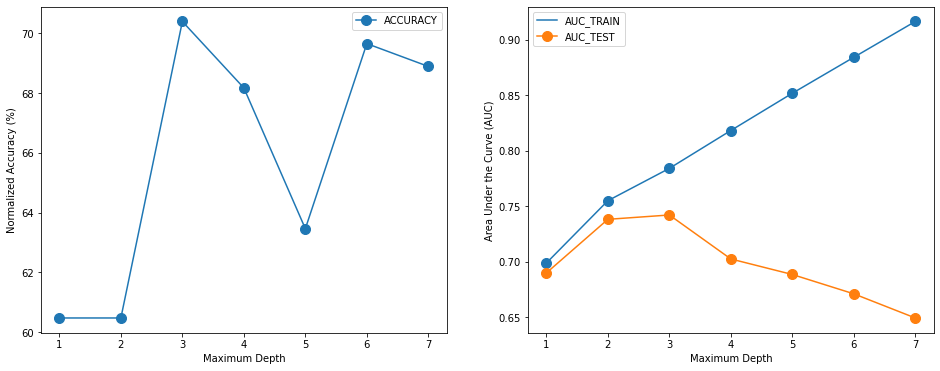

In [49]:
performance_curve_plot(performance_df)

*Choose the max_depth of 3to be the best hyperparameter since after which the AUC for test set starts declining, meaning worse performance.*

In [50]:
estimator = DecisionTreeClassifier(random_state=1147, class_weight='balanced', max_depth=3)
DT = estimator.fit(X_train_annual_scaled, y_train_annual)

5. Plot coeﬃcient values or feature importance.

In [51]:
importances = DT.feature_importances_
importances

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03939233, 0.        , 0.        , 0.03003369,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.21621952, 0.61299881, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.10135565, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

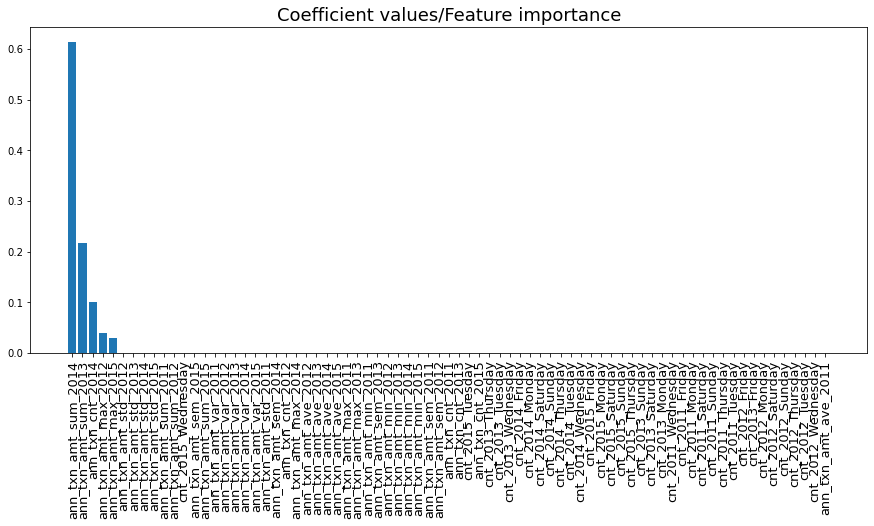

In [52]:
plot_feature_importance(X_annual, importances)

6. Plot probability distribution for test set.

In [53]:
y_test_annual_proba = DT.predict_proba(X_test_annual_scaled)
y_test_annual_proba

array([[0.9791223 , 0.0208777 ],
       [0.58012598, 0.41987402],
       [0.25046719, 0.74953281],
       ...,
       [0.62708852, 0.37291148],
       [0.79072551, 0.20927449],
       [0.25046719, 0.74953281]])

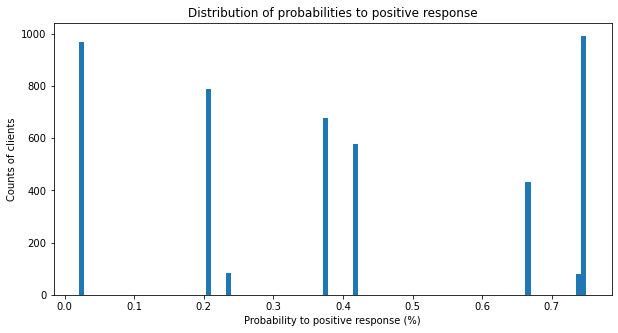

In [54]:
plot_prob_dist(y_test_annual_proba)

7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

##### Train set

In [55]:
y_train_annual_predicted = DT.predict(X_train_annual_scaled)
print(y_train_annual_predicted)

[1 1 0 ... 0 0 0]


In [56]:
cm = confusion_matrix(y_train_annual, y_train_annual_predicted)
print(cm)

[[1505  593]
 [  48  148]]


<Figure size 432x288 with 0 Axes>

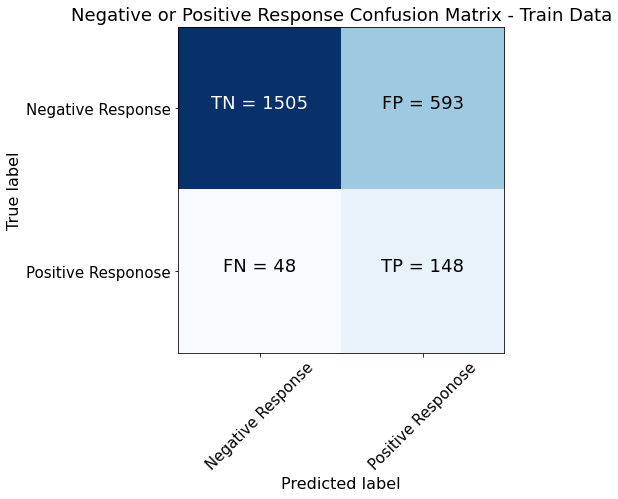

In [57]:
plot_cm(cm, 'Train')

In [58]:
metrics('Train', y_train_annual, y_train_annual_predicted)

Classification Report ( Train ):
                    precision    recall  f1-score   support

Negative Response       0.97      0.72      0.82      2098
Positive Response       0.20      0.76      0.32       196

         accuracy                           0.72      2294
        macro avg       0.58      0.74      0.57      2294
     weighted avg       0.90      0.72      0.78      2294

Accuracy ( Train ): 0.7205754141238012


##### Test set

In [59]:
y_test_annual_predicted = DT.predict(X_test_annual_scaled)
print(y_test_annual_predicted)

[0 0 1 ... 0 0 1]


In [60]:
cm = confusion_matrix(y_test_annual, y_test_annual_predicted)
print(cm)

[[2934 1205]
 [ 154  297]]


<Figure size 432x288 with 0 Axes>

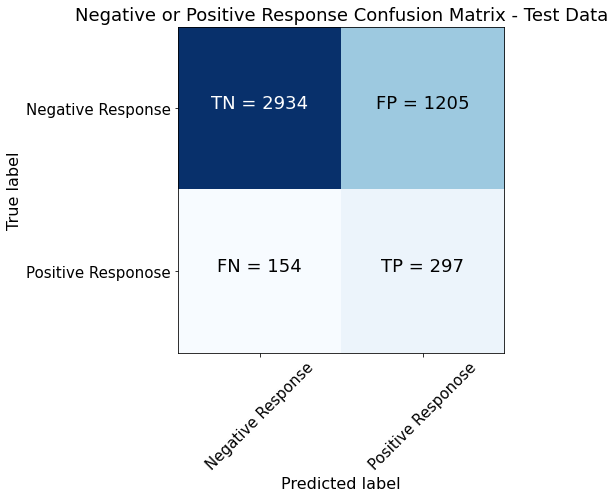

In [61]:
plot_cm(cm, 'Test')

In [62]:
metrics('Test', y_test_annual, y_test_annual_predicted)

Classification Report ( Test ):
                    precision    recall  f1-score   support

Negative Response       0.95      0.71      0.81      4139
Positive Response       0.20      0.66      0.30       451

         accuracy                           0.70      4590
        macro avg       0.57      0.68      0.56      4590
     weighted avg       0.88      0.70      0.76      4590

Accuracy ( Test ): 0.703921568627451


##### ROC

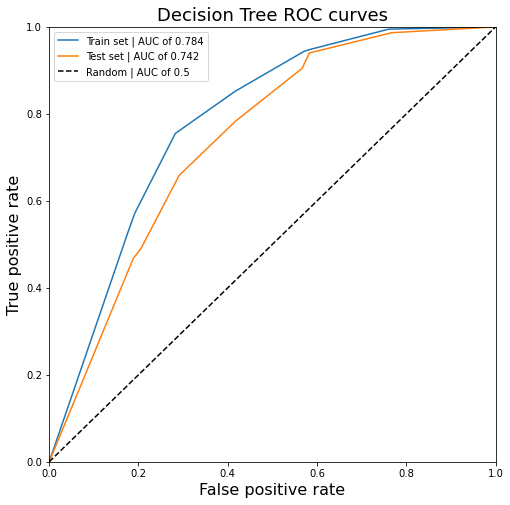

In [63]:
plot_roc(DT, X_train_annual_scaled, X_test_annual_scaled, y_train_annual, y_test_annual, 'Decision Tree')

8. Plot decision boundary for top 2 features.

    The coefficients with the highest values are 'ann_txn_amt_sum_2013' (27th column) and 'ann_txn_amt_sum_2014' (28th column).

In [64]:
feat1, feat2, coef1, coef2, coef1_min, coef1_max, coef2_min, coef2_max = min_max_for_grid(importances,
                                                                                          X_annual,
                                                                                          X_train_annual_scaled)

coefficient 1:  ann_txn_amt_sum_2014 , index:  28
coefficient 2:  ann_txn_amt_sum_2013 , index:  27

--- coefficient 1 ----
min: -1.755266718463368 -> -2.0
max: 3.824668181429266 -> 4.0
difference: 6.0

--- coefficient 2 ----
min: -1.6977424959358869 -> -2.0
max: 5.53912436943854 -> 6.0
difference: 8.0


In [65]:
xx, yy = np.mgrid[coef1_min:coef1_max:0.666, coef2_min:coef2_max:0.888] # The steps were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

(100, 2)


In [66]:
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, X_train_annual.shape[1])) * np.median(X_train_annual_scaled, axis=0) 
pd.DataFrame(median_inputs)

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
1,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
2,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
3,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
4,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
96,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
97,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
98,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195


In [67]:
# Then, we replace the 27th and 28th column with the values of the grid
median_inputs[:,coef1] = grid[:,0]
median_inputs[:,coef2] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:20,:30]
df.style.apply(lambda x: ['background: grey' if (x.name == coef1)|(x.name == coef2)  else '' for i in x])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-2.000000,-2.000000,-0.218893
1,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-1.112000,-2.000000,-0.218893
2,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-0.224000,-2.000000,-0.218893
3,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,0.664000,-2.000000,-0.218893
4,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,1.552000,-2.000000,-0.218893
5,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,2.440000,-2.000000,-0.218893
6,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,3.328000,-2.000000,-0.218893
7,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,4.216000,-2.000000,-0.218893
8,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,5.104000,-2.000000,-0.218893
9,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,5.992000,-2.000000,-0.218893


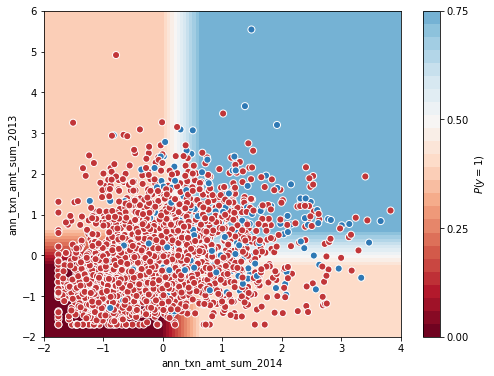

In [68]:
plot_contour(DT, X_train_annual_scaled, y_train_annual, feat1, feat2)

#### Annual Features: Random Forest

4. Fit the training dataset and optimize the hyperparameters of the method.

In [69]:
def rf_tune_param(max_depth, X_train, X_test, y_train, y_test):
    # Initiate some parameters that I want to track in the iteration below
    max_depth_range = range(2, max_depth)
    estimator_max_depth = []
    accuracy_normalized = []
    auc_train           = []
    auc_test            = []

    for i in max_depth_range:
        # Define and fit
        estimator_max_depth.append(RandomForestClassifier(random_state=1147, n_estimators=100, class_weight='balanced', max_depth=i))
        estimator_max_depth[i-2].fit(X_train, y_train)
        # Score train and test set ############### we don't need to store this in every iteration so we can overwrite it ###############
        scores_train = estimator_max_depth[i-2].predict_proba(X_train)[:,1] 
        scores_test  = estimator_max_depth[i-2].predict_proba(X_test)[:,1]  
        # Predict the class of test set
        y_test_predicted = estimator_max_depth[i-2].predict(X_test)
        # Calculate accuracy at every iteration and append
        accuracy_normalized.append(100*accuracy_score(y_test, y_test_predicted, normalize = True))
        # ROC Calc Train set ############### we don't need to store this in every iteration so we can overwrite it ###############
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
        # ROC Calc Test set ############### we don't need to store this in every iteration so we can overwrite it ###############
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
        # Calculate the AUCs
        auc_train.append(auc(fpr_train, tpr_train))
        auc_test.append(auc(fpr_test, tpr_test))
    
    performance_dictionary = {'ACCURACY': accuracy_normalized, 
                              'AUC_TRAIN': auc_train,
                              'AUC_TEST': auc_test}
    performance_df = pd.DataFrame(performance_dictionary)
    performance_df['MAX_DEPTH'] = performance_df.index + 2
    return performance_df


In [70]:
performance_df = rf_tune_param(11, X_train_annual_scaled, X_test_annual_scaled, 
                               y_train_annual, y_test_annual)
performance_df

,ACCURACY,AUC_TRAIN,AUC_TEST,MAX_DEPTH
0,65.250545,0.801782,0.743527,2
1,66.971678,0.832442,0.742638,3
2,70.043573,0.866452,0.744270,4
3,73.747277,0.901446,0.745206,5
4,76.753813,0.933608,0.744154,6
5,79.193900,0.962194,0.745514,7
6,82.832244,0.988026,0.746536,8
7,84.575163,0.993118,0.745020,9
8,85.729847,0.997408,0.746198,10


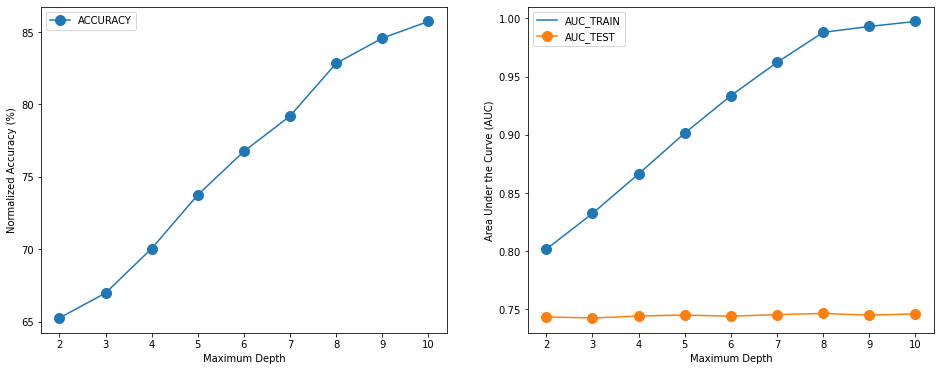

In [71]:
performance_curve_plot(performance_df)

*Choose the max_depth of 8 to be the best hyperparameter since after which the AUC for test set starts declining, meaning worse performance.*

In [72]:
# Define and fit
estimator = RandomForestClassifier(random_state=1147, n_estimators=100, class_weight='balanced', max_depth=8)
RF = estimator.fit(X_train_annual_scaled, y_train_annual)

5. Plot coeﬃcient values or feature importance.

In [73]:
importances = RF.feature_importances_
importances

array([0.01567048, 0.01621746, 0.02990815, 0.02892843, 0.01084126,
       0.01256466, 0.0181554 , 0.02239103, 0.0310091 , 0.01100386,
       0.020276  , 0.02405043, 0.0215782 , 0.02670863, 0.01327262,
       0.01097087, 0.01395236, 0.02635546, 0.0350942 , 0.00793594,
       0.00983908, 0.02063083, 0.02134274, 0.02335439, 0.00643815,
       0.01551502, 0.01680386, 0.05859209, 0.08901686, 0.00944829,
       0.01120001, 0.01314782, 0.01874016, 0.02574498, 0.0055022 ,
       0.00407744, 0.00693649, 0.01826513, 0.07270744, 0.00566708,
       0.00171247, 0.00321635, 0.00201297, 0.00281036, 0.00232951,
       0.00512199, 0.00373006, 0.00361824, 0.00573792, 0.00551008,
       0.00414343, 0.00536311, 0.00361516, 0.00447872, 0.00411475,
       0.00539565, 0.00403595, 0.00479545, 0.00592661, 0.00590202,
       0.00533247, 0.00656939, 0.00514609, 0.00381976, 0.01204259,
       0.00568302, 0.00530015, 0.01057443, 0.00330778, 0.00103936,
       0.00096303, 0.00201684, 0.00160474, 0.00154227, 0.00163

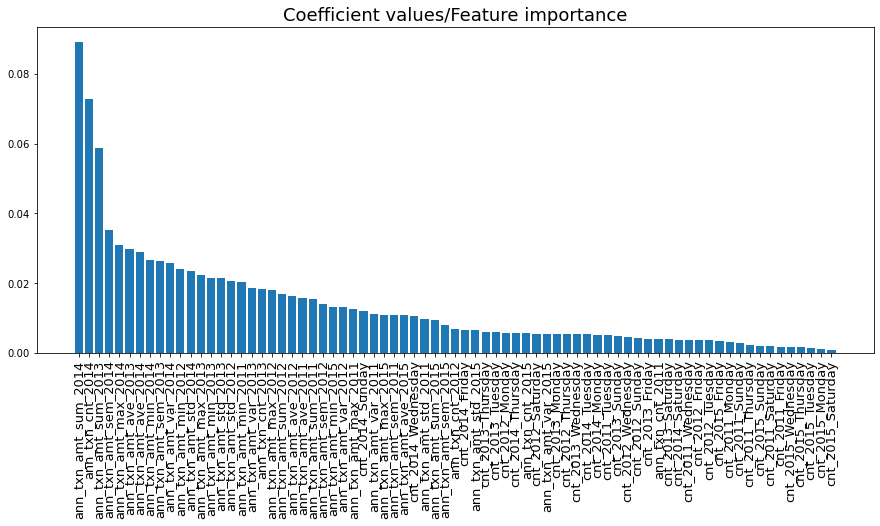

In [74]:
plot_feature_importance(X_annual, importances)

6. Plot probability distribution for test set.

In [75]:
y_test_annual_proba = RF.predict_proba(X_test_annual_scaled)
y_test_annual_proba

array([[0.99618475, 0.00381525],
       [0.78373715, 0.21626285],
       [0.53711046, 0.46288954],
       ...,
       [0.78366244, 0.21633756],
       [0.96531474, 0.03468526],
       [0.40943672, 0.59056328]])

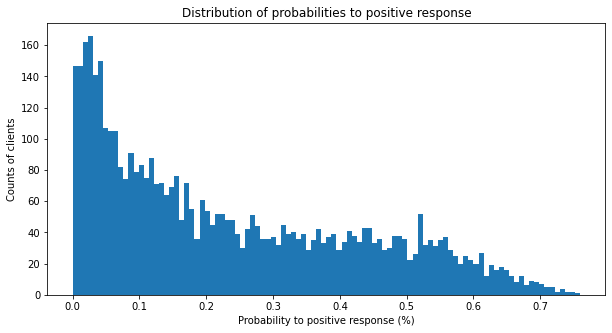

In [76]:
plot_prob_dist(y_test_annual_proba)

7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

##### Train set

In [77]:
y_train_annual_predicted = RF.predict(X_train_annual_scaled)
print(y_train_annual_predicted)

[0 0 0 ... 0 0 0]


In [78]:
cm = confusion_matrix(y_train_annual, y_train_annual_predicted)
print(cm)

[[1916  182]
 [   2  194]]


<Figure size 432x288 with 0 Axes>

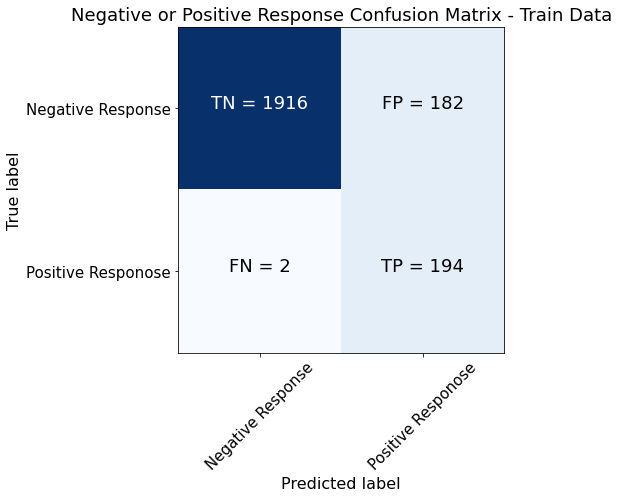

In [79]:
plot_cm(cm, 'Train')

In [80]:
metrics('Train', y_train_annual, y_train_annual_predicted)

Classification Report ( Train ):
                    precision    recall  f1-score   support

Negative Response       1.00      0.91      0.95      2098
Positive Response       0.52      0.99      0.68       196

         accuracy                           0.92      2294
        macro avg       0.76      0.95      0.82      2294
     weighted avg       0.96      0.92      0.93      2294

Accuracy ( Train ): 0.9197907585004359


##### Test set

In [81]:
y_test_annual_predicted = RF.predict(X_test_annual_scaled)
print(y_test_annual_predicted)

[0 0 0 ... 0 0 1]


In [82]:
cm = confusion_matrix(y_test_annual, y_test_annual_predicted)
print(cm)

[[3666  473]
 [ 315  136]]


<Figure size 432x288 with 0 Axes>

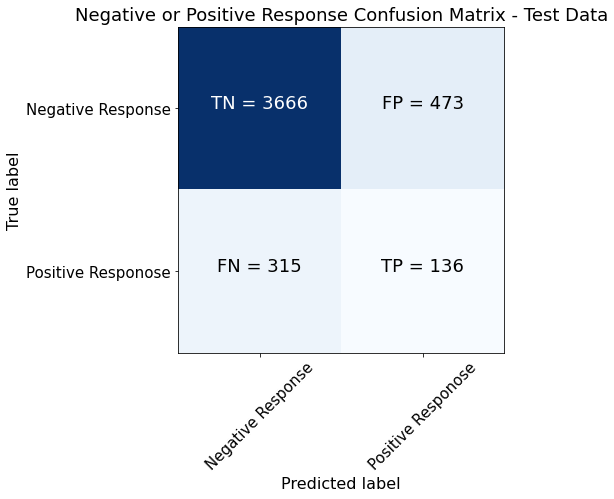

In [83]:
plot_cm(cm, 'Test')

In [84]:
metrics('Test', y_test_annual, y_test_annual_predicted)

Classification Report ( Test ):
                    precision    recall  f1-score   support

Negative Response       0.92      0.89      0.90      4139
Positive Response       0.22      0.30      0.26       451

         accuracy                           0.83      4590
        macro avg       0.57      0.59      0.58      4590
     weighted avg       0.85      0.83      0.84      4590

Accuracy ( Test ): 0.828322440087146


##### ROC

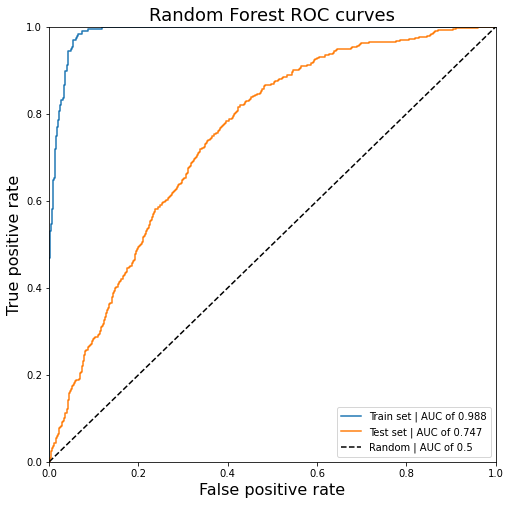

In [85]:
plot_roc(RF, X_train_annual_scaled, X_test_annual_scaled, y_train_annual, y_test_annual, 'Random Forest')

8. Plot decision boundary for top 2 features.

In [86]:
feat1, feat2, coef1, coef2, coef1_min, coef1_max, coef2_min, coef2_max = min_max_for_grid(importances,
                                                                                          X_annual,
                                                                                          X_train_annual_scaled)

coefficient 1:  ann_txn_amt_sum_2014 , index:  28
coefficient 2:  ann_txn_cnt_2014 , index:  38

--- coefficient 1 ----
min: -1.755266718463368 -> -2.0
max: 3.824668181429266 -> 4.0
difference: 6.0

--- coefficient 2 ----
min: -2.0870367135984464 -> -3.0
max: 3.6694938887815822 -> 4.0
difference: 7.0


In [87]:
xx, yy = np.mgrid[coef1_min:coef1_max:0.666, coef2_min:coef2_max:0.777] # The steps were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

(100, 2)


In [88]:
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, X_train_annual.shape[1])) * np.median(X_train_annual_scaled, axis=0) 
pd.DataFrame(median_inputs)

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
1,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
2,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
3,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
4,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
96,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
97,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195
98,0.207915,0.193815,0.200782,0.20405,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,...,-0.846345,-0.211053,0.327716,-0.385544,-0.389388,-0.355696,-0.369652,-0.374629,-0.383507,-0.37195


In [89]:
# Then, we replace the 28th and 38th column with the values of the grid
median_inputs[:,coef1] = grid[:,0]
median_inputs[:,coef2] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:20,:40]
df.style.apply(lambda x: ['background: grey' if (x.name == coef1)|(x.name == coef2)  else '' for i in x])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-0.117941,-2.000000,-0.218893,-0.232316,-0.076308,-0.103054,-0.097714,-0.358583,0.016910,-0.292639,0.096226,-3.000000,0.011929
1,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-0.117941,-2.000000,-0.218893,-0.232316,-0.076308,-0.103054,-0.097714,-0.358583,0.016910,-0.292639,0.096226,-2.223000,0.011929
2,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-0.117941,-2.000000,-0.218893,-0.232316,-0.076308,-0.103054,-0.097714,-0.358583,0.016910,-0.292639,0.096226,-1.446000,0.011929
3,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-0.117941,-2.000000,-0.218893,-0.232316,-0.076308,-0.103054,-0.097714,-0.358583,0.016910,-0.292639,0.096226,-0.669000,0.011929
4,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-0.117941,-2.000000,-0.218893,-0.232316,-0.076308,-0.103054,-0.097714,-0.358583,0.016910,-0.292639,0.096226,0.108000,0.011929
5,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-0.117941,-2.000000,-0.218893,-0.232316,-0.076308,-0.103054,-0.097714,-0.358583,0.016910,-0.292639,0.096226,0.885000,0.011929
6,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-0.117941,-2.000000,-0.218893,-0.232316,-0.076308,-0.103054,-0.097714,-0.358583,0.016910,-0.292639,0.096226,1.662000,0.011929
7,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-0.117941,-2.000000,-0.218893,-0.232316,-0.076308,-0.103054,-0.097714,-0.358583,0.016910,-0.292639,0.096226,2.439000,0.011929
8,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-0.117941,-2.000000,-0.218893,-0.232316,-0.076308,-0.103054,-0.097714,-0.358583,0.016910,-0.292639,0.096226,3.216000,0.011929
9,0.207915,0.193815,0.200782,0.204050,0.133991,0.190266,0.294652,0.305206,0.284052,0.086339,-0.041356,-0.068578,-0.019906,-0.030642,0.062788,-0.004605,-0.100143,-0.103779,-0.103324,-0.460524,0.112162,0.149067,0.128105,0.119628,-0.466629,-0.151112,-0.112405,-0.117941,-2.000000,-0.218893,-0.232316,-0.076308,-0.103054,-0.097714,-0.358583,0.016910,-0.292639,0.096226,3.993000,0.011929


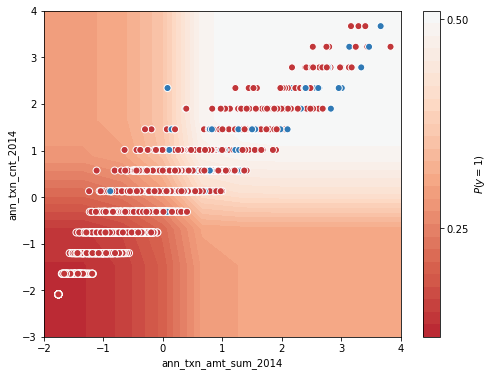

In [90]:
plot_contour(RF, X_train_annual_scaled, y_train_annual, feat1, feat2)

### 2) Monthly Features

1. Separate the inputs **X** and the output **y** in two data frames.

In [91]:
X_monthly = monthly_features_outputs.drop(['response', 'CLNT_NO', 'ME_DT'], axis = 1)
y_monthly = monthly_features_outputs['response']

In [92]:
y_monthly.value_counts()

0    293139
1     30409
Name: response, dtype: int64

In [93]:
# replace NaN values with 0
X_monthly.fillna(0, inplace = True)

2. Split the data in train and test set. Use a test size value of 2/3 and set the random state equal to 1147 for consistency (i.e. the course code value). Use the following names for consistency.

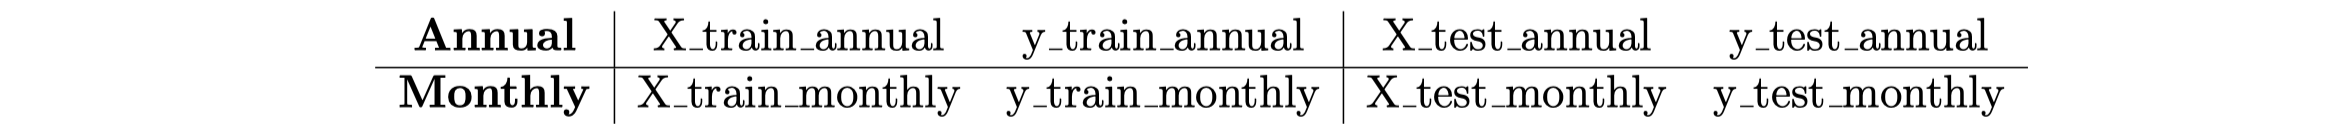

In [94]:
# Split in train and test sets
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly,
                                                                                    test_size=2/3,
                                                                                    random_state=1147)

3. Pre-process (if necessary for the method).

In [95]:
# replace NaN values with 0
X_train_monthly.fillna(0, inplace = True)
X_test_monthly.fillna(0, inplace = True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [96]:
# Create the instance of the scaler
scaler = StandardScaler()

# Transform the inputs X
X_train_monthly_scaled = scaler.fit_transform(X_train_monthly)
X_test_monthly_scaled = scaler.transform(X_test_monthly)

X_train_monthly_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

####  Monthly Features: L1 log-reg

4. Fit the training dataset and optimize the hyperparameters of the method.

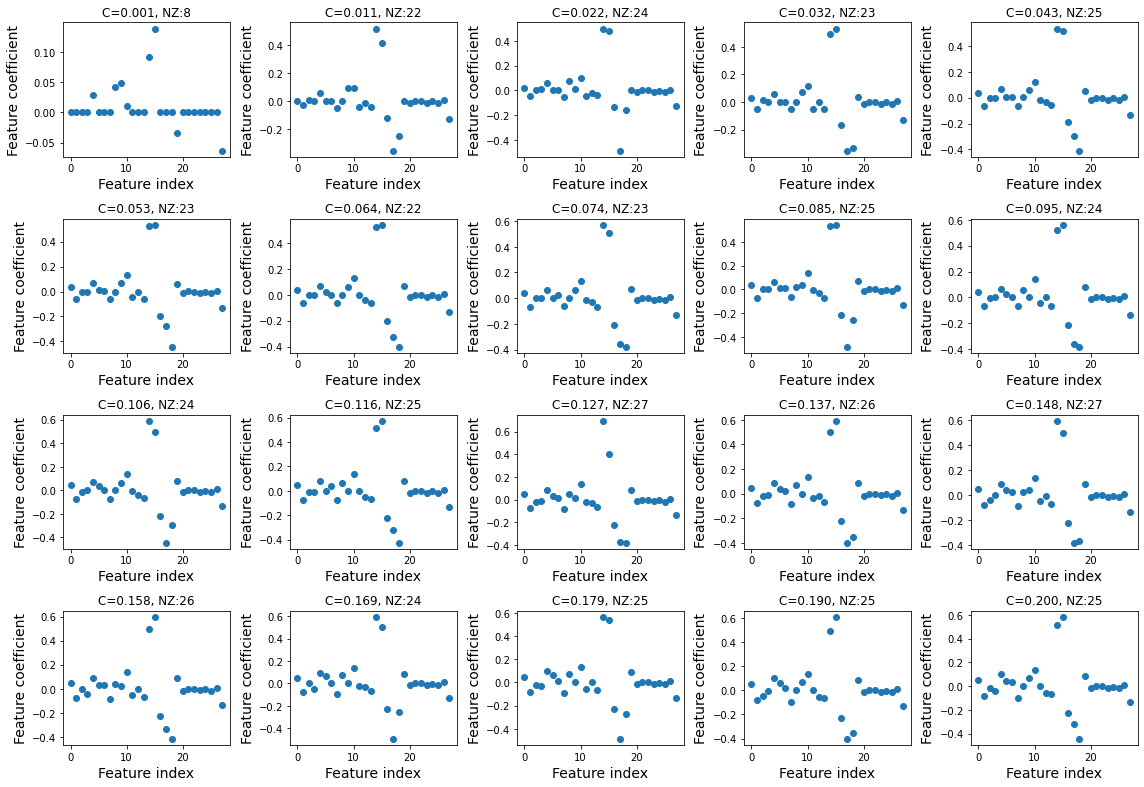

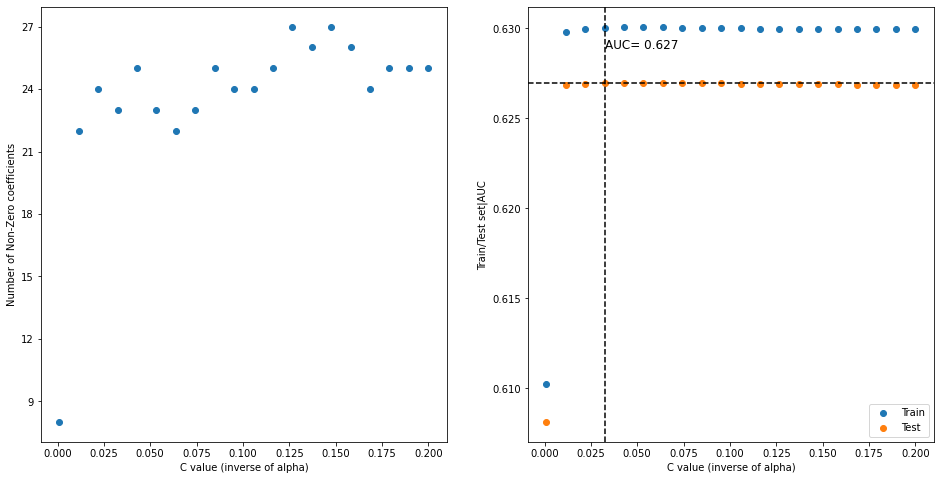

In [97]:
C = np.linspace(0.001, 0.2, 20)
lr_tune_param_plot(C, 3, X_monthly, X_train_monthly_scaled, X_test_monthly_scaled, y_train_monthly, y_test_monthly)

*Choose the 4th (index 3) value of C = 0.032 to be the best hyperparameter since after which the AUC for test set starts declining, meaning worse performance.*

In [98]:
LogReg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=C[3])
LogReg.fit(X_train_monthly_scaled, y_train_monthly)

LogisticRegression(C=0.03242105263157895, class_weight='balanced', penalty='l1',
                   solver='liblinear')

5. Plot coeﬃcient values or feature importance.

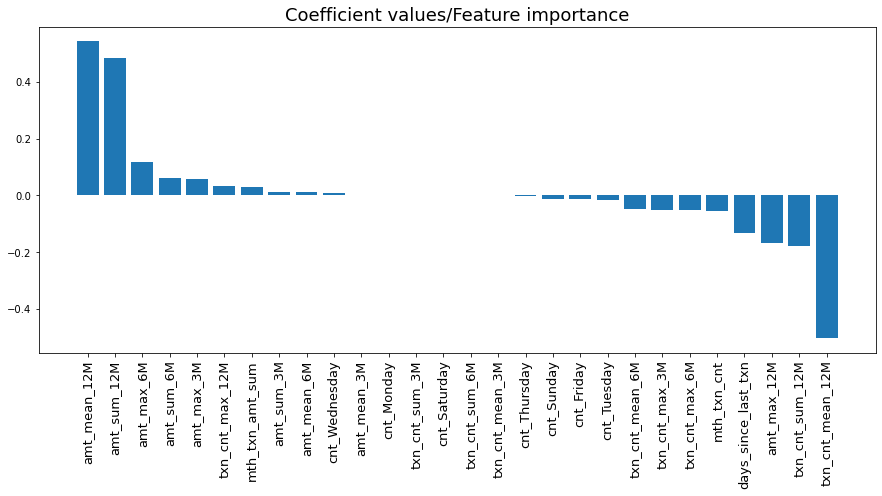

In [99]:
importances = LogReg.coef_[0]
plot_feature_importance(X_monthly, importances)

6. Plot probability distribution for test set.

In [100]:
y_test_monthly_proba = LogReg.predict_proba(X_test_monthly_scaled)
y_test_monthly_proba

array([[0.54553651, 0.45446349],
       [0.45658273, 0.54341727],
       [0.53421607, 0.46578393],
       ...,
       [0.63392872, 0.36607128],
       [0.63508822, 0.36491178],
       [0.72544892, 0.27455108]])

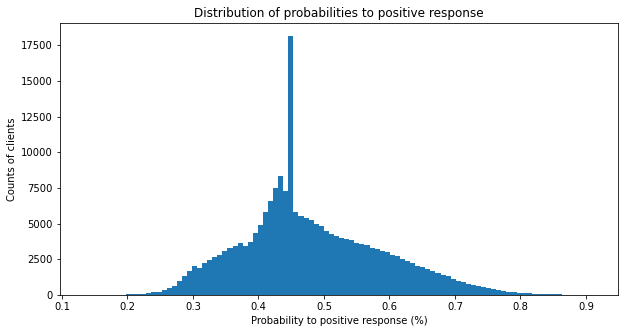

In [101]:
plot_prob_dist(y_test_monthly_proba)

7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

##### Train Set

In [102]:
y_train_monthly_predicted = LogReg.predict(X_train_monthly_scaled)
print(y_train_monthly_predicted)

[1 0 0 ... 0 1 1]


In [103]:
cm = confusion_matrix(y_train_monthly, y_train_monthly_predicted)
print(cm)

[[63053 34689]
 [ 4734  5373]]


<Figure size 432x288 with 0 Axes>

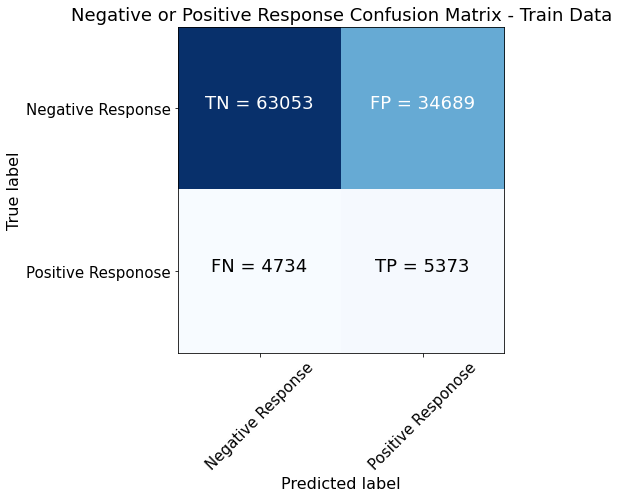

In [104]:
plot_cm(cm, 'Train')

In [105]:
metrics('Train', y_train_monthly, y_train_monthly_predicted)

Classification Report ( Train ):
                    precision    recall  f1-score   support

Negative Response       0.93      0.65      0.76     97742
Positive Response       0.13      0.53      0.21     10107

         accuracy                           0.63    107849
        macro avg       0.53      0.59      0.49    107849
     weighted avg       0.86      0.63      0.71    107849

Accuracy ( Train ): 0.6344611447486764


##### Test Set

In [106]:
y_test_monthly_predicted = LogReg.predict(X_test_monthly_scaled)
print(y_test_monthly_predicted)

[0 1 0 ... 0 0 0]


In [107]:
cm = confusion_matrix(y_test_monthly, y_test_monthly_predicted)
print(cm)

[[125910  69487]
 [  9584  10718]]


<Figure size 432x288 with 0 Axes>

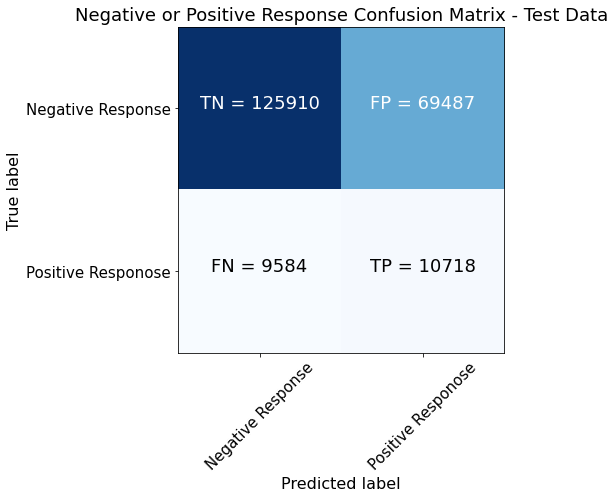

In [108]:
plot_cm(cm, 'Test')

In [109]:
metrics('Test', y_test_monthly, y_test_monthly_predicted)

Classification Report ( Test ):
                    precision    recall  f1-score   support

Negative Response       0.93      0.64      0.76    195397
Positive Response       0.13      0.53      0.21     20302

         accuracy                           0.63    215699
        macro avg       0.53      0.59      0.49    215699
     weighted avg       0.85      0.63      0.71    215699

Accuracy ( Test ): 0.6334197191456613


##### ROC

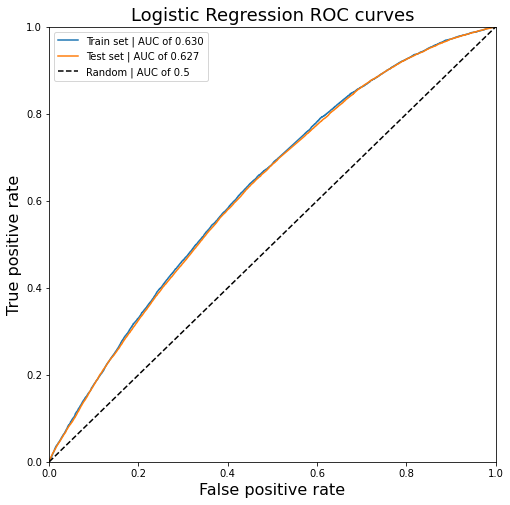

In [110]:
plot_roc(LogReg, X_train_monthly_scaled, X_test_monthly_scaled, y_train_monthly, y_test_monthly, 
         'Logistic Regression')

8. Plot decision boundary for top 2 features.

In [111]:
feat1, feat2, coef1, coef2, coef1_min, coef1_max, coef2_min, coef2_max = min_max_for_grid(importances,
                                                                                          X_monthly,
                                                                                          X_train_monthly_scaled)

coefficient 1:  amt_mean_12M , index:  15
coefficient 2:  amt_sum_12M , index:  14

--- coefficient 1 ----
min: -1.1658179438201839 -> -2.0
max: 4.862714417611843 -> 5.0
difference: 7.0

--- coefficient 2 ----
min: -1.1658179438201837 -> -2.0
max: 4.862714417611841 -> 5.0
difference: 7.0


In [112]:
xx, yy = np.mgrid[coef1_min:coef1_max:0.777, coef2_min:coef2_max:0.777] # The steps were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

(100, 2)


In [113]:
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, X_train_monthly.shape[1])) * np.median(X_train_monthly_scaled, axis=0) 
pd.DataFrame(median_inputs)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
1,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
2,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
3,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
4,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
96,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
97,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
98,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471


In [114]:
# Then, we replace the 15th and 14th column with the values of the grid
median_inputs[:,coef1] = grid[:,0]
median_inputs[:,coef2] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:20,:20]
df.style.apply(lambda x: ['background: grey' if (x.name == coef1)|(x.name == coef2)  else '' for i in x])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-2.000000,0.014035,0.132418,0.132418,-0.250774
1,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-1.223000,-2.000000,0.014035,0.132418,0.132418,-0.250774
2,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-0.446000,-2.000000,0.014035,0.132418,0.132418,-0.250774
3,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,0.331000,-2.000000,0.014035,0.132418,0.132418,-0.250774
4,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,1.108000,-2.000000,0.014035,0.132418,0.132418,-0.250774
5,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,1.885000,-2.000000,0.014035,0.132418,0.132418,-0.250774
6,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,2.662000,-2.000000,0.014035,0.132418,0.132418,-0.250774
7,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,3.439000,-2.000000,0.014035,0.132418,0.132418,-0.250774
8,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,4.216000,-2.000000,0.014035,0.132418,0.132418,-0.250774
9,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,4.993000,-2.000000,0.014035,0.132418,0.132418,-0.250774


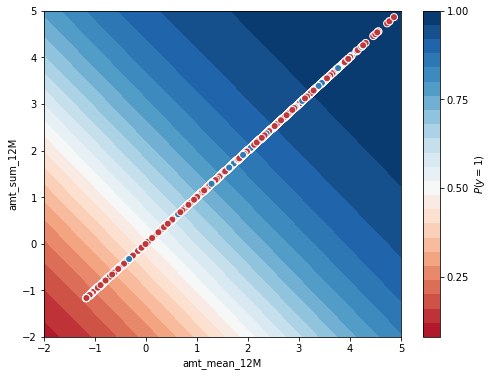

In [115]:
plot_contour(LogReg, X_train_monthly_scaled, y_train_monthly, feat1, feat2)

#### Monthly Features: Decision Tree

4. Fit the training dataset and optimize the hyperparameters of the method.

In [116]:
performance_df = dt_tune_param(11, X_train_monthly_scaled, X_test_monthly_scaled, y_train_monthly, y_test_monthly)
performance_df

,ACCURACY,AUC_TRAIN,AUC_TEST,MAX_DEPTH
0,61.424485,0.595693,0.590467,1
1,61.424485,0.625082,0.620261,2
2,61.576085,0.635699,0.631349,3
3,58.114317,0.641477,0.636744,4
4,58.562163,0.646289,0.637231,5
5,57.889930,0.652061,0.637487,6
6,55.519497,0.659198,0.637375,7
7,54.813421,0.669029,0.637114,8
8,55.872767,0.682099,0.632665,9
9,53.776791,0.697814,0.628969,10


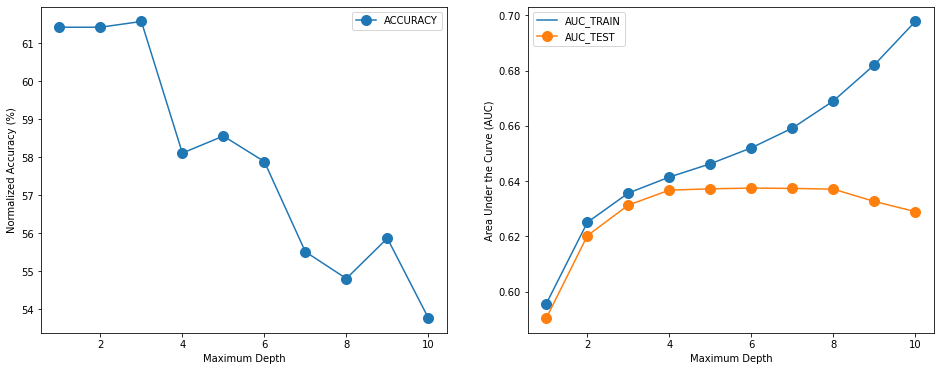

In [117]:
performance_curve_plot(performance_df)

*Choose the max_depth of 4 to be the best hyperparameter since after which the AUC for test set starts declining, meaning worse performance.*

In [118]:
estimator = DecisionTreeClassifier(random_state=1147, class_weight='balanced', max_depth=4)
DT = estimator.fit(X_train_monthly_scaled, y_train_monthly)

5. Plot coeﬃcient values or feature importance.

In [119]:
importances = DT.feature_importances_
importances

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0045284 , 0.        ,
       0.01071662, 0.        , 0.        , 0.        , 0.58996347,
       0.01129481, 0.33314745, 0.        , 0.02206741, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02828184])

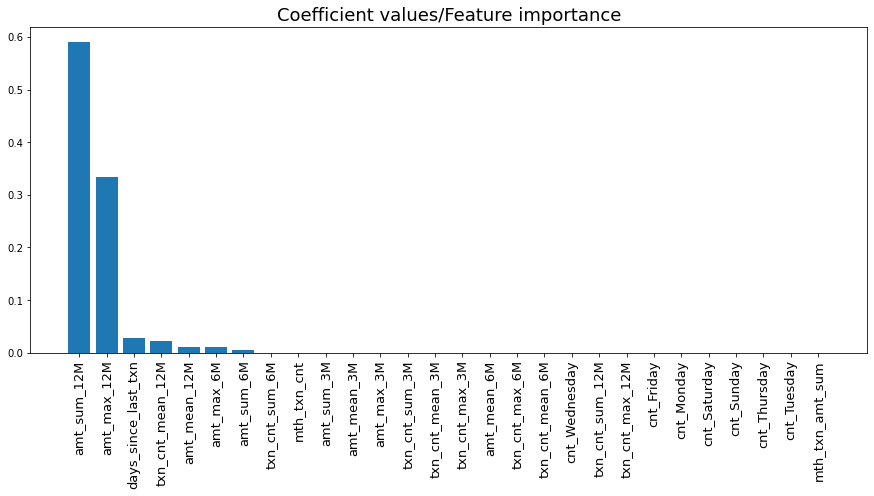

In [120]:
plot_feature_importance(X_monthly, importances)

6. Plot probability distribution for test set.

In [121]:
y_test_monthly_proba = DT.predict_proba(X_test_monthly_scaled)
y_test_monthly_proba

array([[0.46197063, 0.53802937],
       [0.41010768, 0.58989232],
       [0.71721856, 0.28278144],
       ...,
       [0.88930185, 0.11069815],
       [0.71721856, 0.28278144],
       [0.88930185, 0.11069815]])

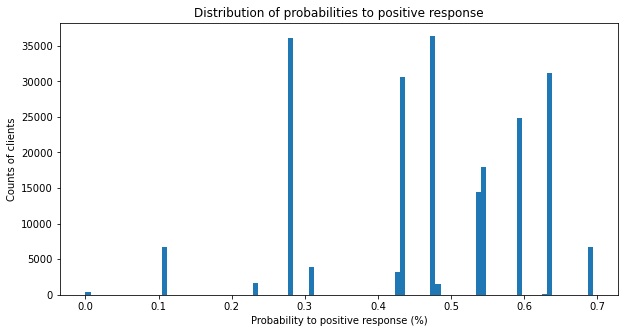

In [122]:
plot_prob_dist(y_test_monthly_proba)

7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

##### Train set

In [123]:
y_train_monthly_predicted = DT.predict(X_train_monthly_scaled)
print(y_train_monthly_predicted)

[1 0 0 ... 0 1 0]


In [124]:
cm = confusion_matrix(y_train_monthly, y_train_monthly_predicted)
print(cm)

[[56368 41374]
 [ 3726  6381]]


<Figure size 432x288 with 0 Axes>

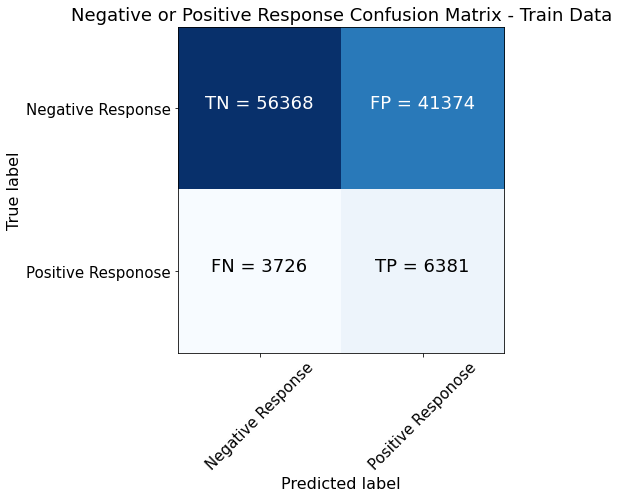

In [125]:
plot_cm(cm, 'Train')

In [126]:
metrics('Train', y_train_monthly, y_train_monthly_predicted)

Classification Report ( Train ):
                    precision    recall  f1-score   support

Negative Response       0.94      0.58      0.71     97742
Positive Response       0.13      0.63      0.22     10107

         accuracy                           0.58    107849
        macro avg       0.54      0.60      0.47    107849
     weighted avg       0.86      0.58      0.67    107849

Accuracy ( Train ): 0.5818227336368441


##### Test Set

In [127]:
y_test_monthly_predicted = DT.predict(X_test_monthly_scaled)
print(y_test_monthly_predicted)

[1 1 0 ... 0 0 0]


In [128]:
cm = confusion_matrix(y_test_monthly, y_test_monthly_predicted)
print(cm)

[[112737  82660]
 [  7687  12615]]


<Figure size 432x288 with 0 Axes>

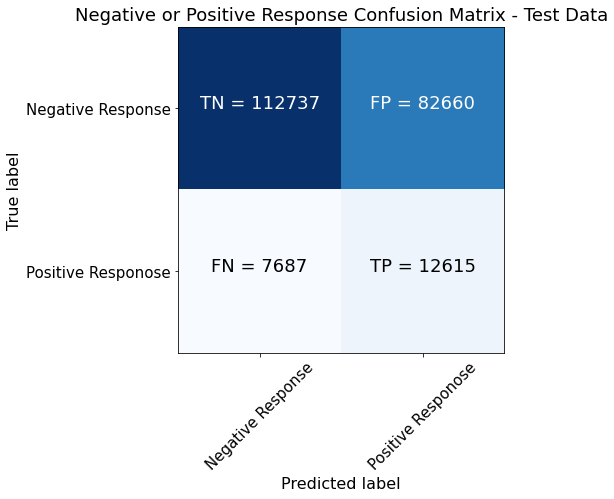

In [129]:
plot_cm(cm, 'Test')

In [130]:
metrics('Test', y_test_monthly, y_test_monthly_predicted)

Classification Report ( Test ):
                    precision    recall  f1-score   support

Negative Response       0.94      0.58      0.71    195397
Positive Response       0.13      0.62      0.22     20302

         accuracy                           0.58    215699
        macro avg       0.53      0.60      0.47    215699
     weighted avg       0.86      0.58      0.67    215699

Accuracy ( Test ): 0.5811431670985957


##### ROC

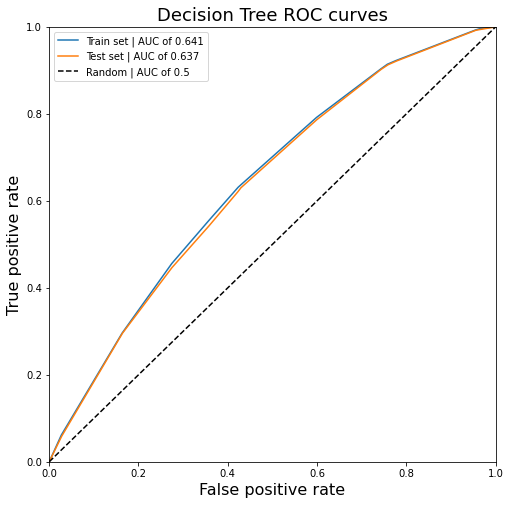

In [131]:
plot_roc(DT, X_train_monthly_scaled, X_test_monthly_scaled, y_train_monthly, y_test_monthly, 'Decision Tree')

8. Plot decision boundary for top 2 features.

In [132]:
feat1, feat2, coef1, coef2, coef1_min, coef1_max, coef2_min, coef2_max = min_max_for_grid(importances,
                                                                                          X_monthly,
                                                                                          X_train_monthly_scaled)

coefficient 1:  amt_sum_12M , index:  14
coefficient 2:  amt_max_12M , index:  16

--- coefficient 1 ----
min: -1.1658179438201837 -> -2.0
max: 4.862714417611841 -> 5.0
difference: 7.0

--- coefficient 2 ----
min: -1.3042030288026143 -> -2.0
max: 5.586586966127264 -> 6.0
difference: 8.0


In [133]:
xx, yy = np.mgrid[coef1_min:coef1_max:0.777, coef2_min:coef2_max:0.888] # The steps were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

(100, 2)


In [134]:
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, X_train_monthly.shape[1])) * np.median(X_train_monthly_scaled, axis=0) 
pd.DataFrame(median_inputs)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
1,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
2,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
3,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
4,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
96,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
97,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
98,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471


In [135]:
median_inputs[:,coef1] = grid[:,0]
median_inputs[:,coef2] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:20,:20]
df.style.apply(lambda x: ['background: grey' if (x.name == coef1)|(x.name == coef2)  else '' for i in x])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-0.100794,-2.000000,0.132418,0.132418,-0.250774
1,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-0.100794,-1.112000,0.132418,0.132418,-0.250774
2,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-0.100794,-0.224000,0.132418,0.132418,-0.250774
3,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-0.100794,0.664000,0.132418,0.132418,-0.250774
4,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-0.100794,1.552000,0.132418,0.132418,-0.250774
5,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-0.100794,2.440000,0.132418,0.132418,-0.250774
6,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-0.100794,3.328000,0.132418,0.132418,-0.250774
7,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-0.100794,4.216000,0.132418,0.132418,-0.250774
8,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-0.100794,5.104000,0.132418,0.132418,-0.250774
9,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-0.100794,5.992000,0.132418,0.132418,-0.250774


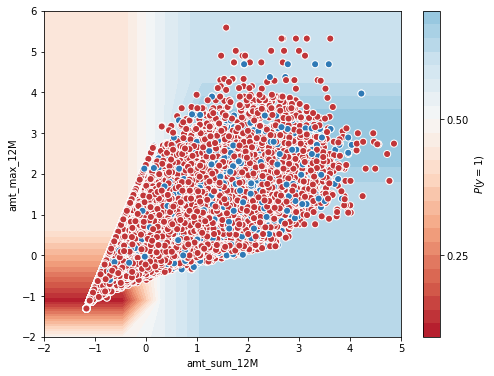

In [136]:
plot_contour(DT, X_train_monthly_scaled, y_train_monthly, feat1, feat2)

#### Monthly Features: Random Forest

4. Fit the training dataset and optimize the hyperparameters of the method.

In [137]:
performance_df = rf_tune_param(16, X_train_monthly_scaled, X_test_monthly_scaled, 
                               y_train_monthly, y_test_monthly)
performance_df

,ACCURACY,AUC_TRAIN,AUC_TEST,MAX_DEPTH
0,60.171350,0.636381,0.631647,2
1,59.741121,0.641953,0.636169,3
2,58.848673,0.646880,0.639419,4
3,57.155110,0.653305,0.641739,5
4,57.368370,0.663125,0.644194,6
5,58.178758,0.675796,0.646018,7
6,59.413813,0.692422,0.647532,8
7,61.147247,0.714118,0.647673,9
8,63.282630,0.738079,0.648077,10
9,65.182963,0.768372,0.648117,11


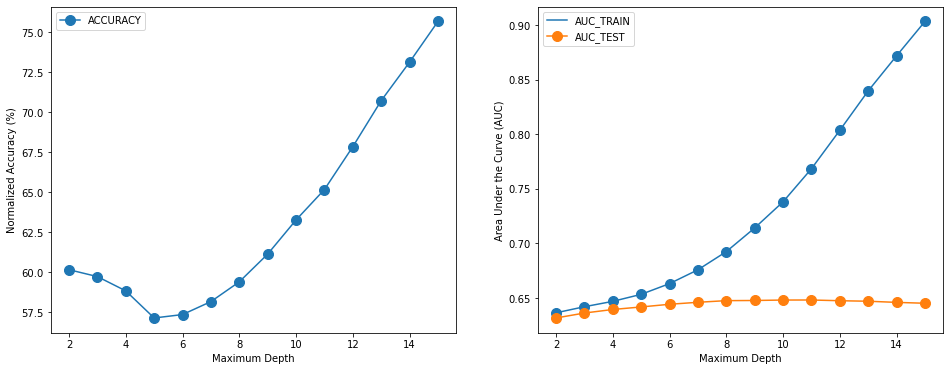

In [138]:
performance_curve_plot(performance_df)

*Choose the max_depth of 11 to be the best hyperparameter since after which the AUC for test set starts declining, meaning worse performance.*

In [139]:
# Define and fit
estimator = RandomForestClassifier(random_state=1147, n_estimators=100, class_weight='balanced', max_depth=11)
RF = estimator.fit(X_train_monthly_scaled, y_train_monthly)

5. Plot coeﬃcient values or feature importance.

In [140]:
importances = RF.feature_importances_
importances

array([0.02644745, 0.00541322, 0.03954322, 0.04078804, 0.04426764,
       0.00725945, 0.00737977, 0.00609364, 0.06273756, 0.08068233,
       0.08042621, 0.01227046, 0.01396194, 0.00937295, 0.13889367,
       0.12427306, 0.0922755 , 0.04389503, 0.04451468, 0.01765795,
       0.00386487, 0.00384368, 0.00416055, 0.00431367, 0.00408012,
       0.00349254, 0.0036738 , 0.07441698])

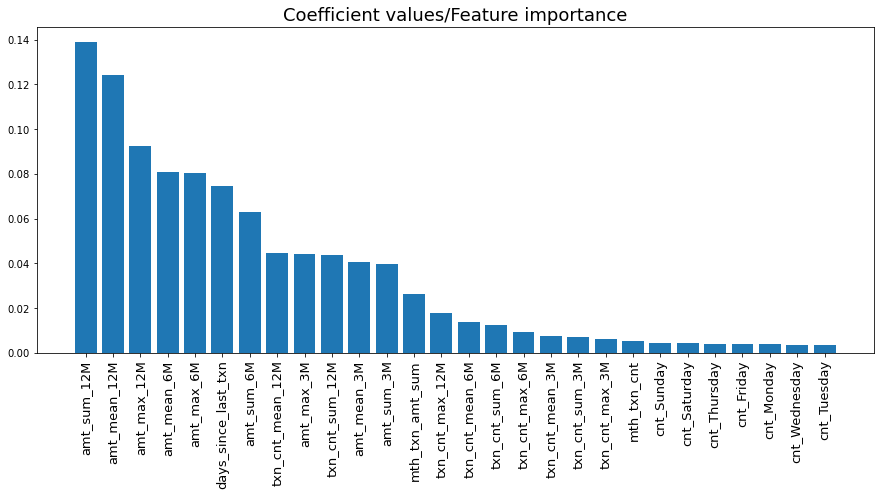

In [141]:
plot_feature_importance(X_monthly, importances)

6. Plot probability distribution for test set.

In [142]:
y_test_monthly_proba = RF.predict_proba(X_test_monthly_scaled)
y_test_monthly_proba

array([[0.50904398, 0.49095602],
       [0.40890184, 0.59109816],
       [0.70919954, 0.29080046],
       ...,
       [0.95676424, 0.04323576],
       [0.73936246, 0.26063754],
       [0.88480839, 0.11519161]])

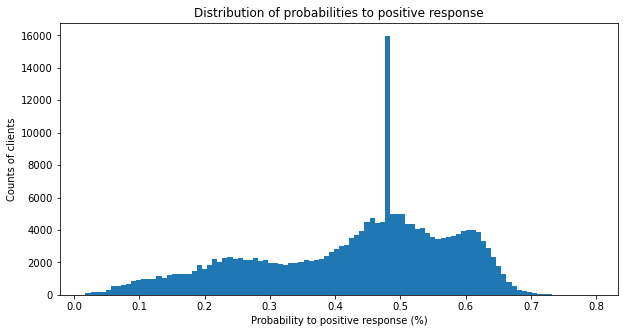

In [143]:
plot_prob_dist(y_test_monthly_proba)

7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

##### Train set

In [144]:
y_train_monthly_predicted = RF.predict(X_train_monthly_scaled)
print(y_train_monthly_predicted)

[1 0 0 ... 0 0 0]


In [145]:
cm = confusion_matrix(y_train_monthly, y_train_monthly_predicted)
print(cm)

[[66390 31352]
 [ 2860  7247]]


<Figure size 432x288 with 0 Axes>

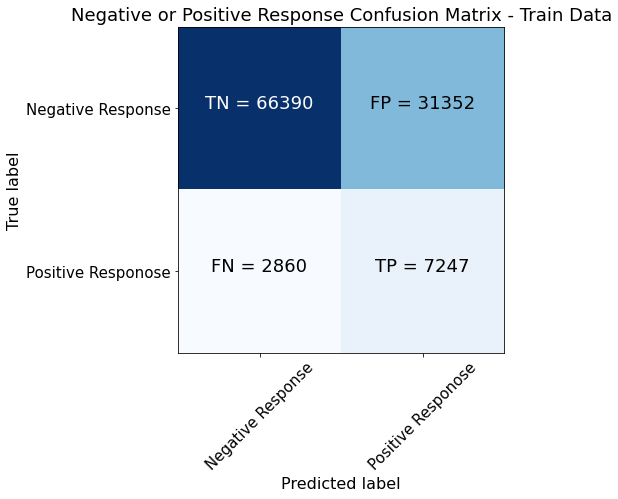

In [146]:
plot_cm(cm, 'Train')

In [147]:
metrics('Train', y_train_monthly, y_train_monthly_predicted)

Classification Report ( Train ):
                    precision    recall  f1-score   support

Negative Response       0.96      0.68      0.80     97742
Positive Response       0.19      0.72      0.30     10107

         accuracy                           0.68    107849
        macro avg       0.57      0.70      0.55    107849
     weighted avg       0.89      0.68      0.75    107849

Accuracy ( Train ): 0.6827786998488627


##### Test set

In [148]:
y_test_monthly_predicted = RF.predict(X_test_monthly_scaled)
print(y_test_monthly_predicted)

[0 1 0 ... 0 0 0]


In [149]:
cm = confusion_matrix(y_test_monthly, y_test_monthly_predicted)
print(cm)

[[129780  65617]
 [  9483  10819]]


<Figure size 432x288 with 0 Axes>

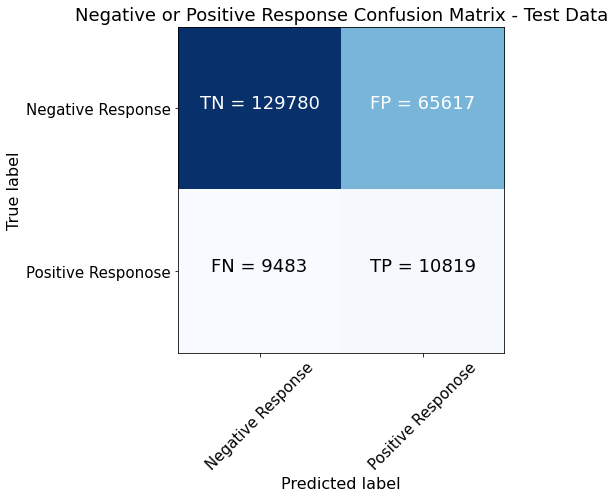

In [150]:
plot_cm(cm, 'Test')

In [151]:
metrics('Test', y_test_monthly, y_test_monthly_predicted)

Classification Report ( Test ):
                    precision    recall  f1-score   support

Negative Response       0.93      0.66      0.78    195397
Positive Response       0.14      0.53      0.22     20302

         accuracy                           0.65    215699
        macro avg       0.54      0.60      0.50    215699
     weighted avg       0.86      0.65      0.72    215699

Accuracy ( Test ): 0.6518296329607463


##### ROC

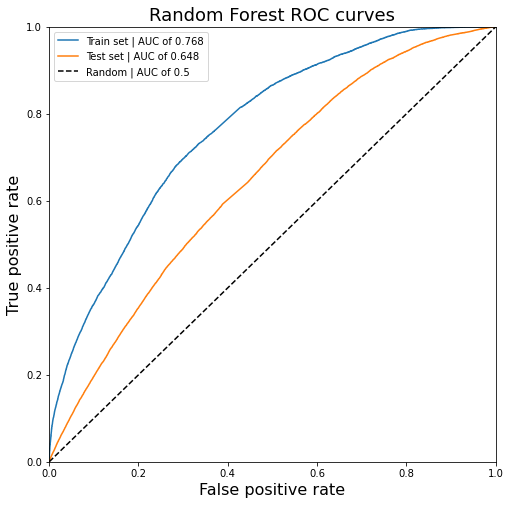

In [152]:
plot_roc(RF, X_train_monthly_scaled, X_test_monthly_scaled, y_train_monthly, y_test_monthly, 'Random Forest')

8. Plot decision boundary for top 2 features.

In [153]:
feat1, feat2, coef1, coef2, coef1_min, coef1_max, coef2_min, coef2_max = min_max_for_grid(importances,
                                                                                          X_monthly,
                                                                                          X_train_monthly_scaled)

coefficient 1:  amt_sum_12M , index:  14
coefficient 2:  amt_mean_12M , index:  15

--- coefficient 1 ----
min: -1.1658179438201837 -> -2.0
max: 4.862714417611841 -> 5.0
difference: 7.0

--- coefficient 2 ----
min: -1.1658179438201839 -> -2.0
max: 4.862714417611843 -> 5.0
difference: 7.0


In [154]:
xx, yy = np.mgrid[coef1_min:coef1_max:0.777, coef2_min:coef2_max:0.777] # The steps were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
print(grid.shape) # Confirm that grid shape is 10x10

(100, 2)


In [155]:
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, X_train_monthly.shape[1])) * np.median(X_train_monthly_scaled, axis=0) 
pd.DataFrame(median_inputs)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
1,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
2,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
3,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
4,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
96,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
97,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471
98,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.16911,-0.16911,...,0.132418,-0.250774,-0.23237,-0.234781,-0.235255,-0.233913,-0.234733,-0.235777,-0.235977,-0.320471


In [156]:
median_inputs[:,coef1] = grid[:,0]
median_inputs[:,coef2] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:20,:20]
df.style.apply(lambda x: ['background: grey' if (x.name == coef1)|(x.name == coef2)  else '' for i in x])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-2.000000,0.014035,0.132418,0.132418,-0.250774
1,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-1.223000,0.014035,0.132418,0.132418,-0.250774
2,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,-0.446000,0.014035,0.132418,0.132418,-0.250774
3,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,0.331000,0.014035,0.132418,0.132418,-0.250774
4,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,1.108000,0.014035,0.132418,0.132418,-0.250774
5,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,1.885000,0.014035,0.132418,0.132418,-0.250774
6,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,2.662000,0.014035,0.132418,0.132418,-0.250774
7,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,3.439000,0.014035,0.132418,0.132418,-0.250774
8,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,4.216000,0.014035,0.132418,0.132418,-0.250774
9,-0.578029,-0.619104,-0.193219,-0.193219,-0.025395,-0.114168,-0.114168,0.212368,-0.169110,-0.169110,-0.011853,-0.066514,-0.066514,-0.156782,-2.000000,4.993000,0.014035,0.132418,0.132418,-0.250774


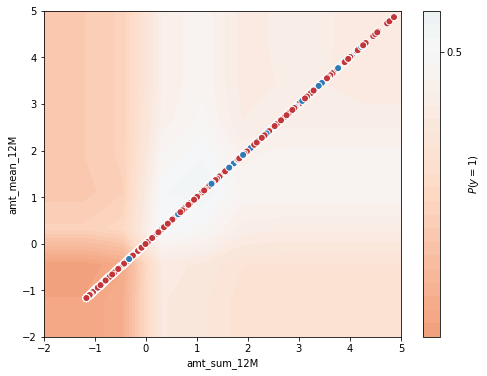

In [157]:
plot_contour(RF, X_train_monthly_scaled, y_train_monthly, feat1, feat2)

### 1.3 Comparison of methods (10 points)

Compare the two feature engineering (annual and monthly) and the three modeling approaches (L1 log-reg, tree, forests) in terms of the outcomes of steps 5-8. Which combination of feature engineering and modeling approach do you select as the best to deploy in a production environment and why? **Tabularize** your ﬁndings in steps 5-8 to summarize the results and support your decision (how to organize information with tables in Markdown).

| Feature | Model | Top 2 features |  Precision (negative) | Precision (positive) | Recall (negative) | Recall (positive) | Train Accuracy | Test Accuracy | Train AUC | Test AUC |
| ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | 
| **Annual** | **L1 Log-Reg** | ann_txn_amt_sum_2014, ann_txn_amt_sum_2013 | 0.96 |  0.20 | 0.68 | 0.73 | 0.70 | 0.69 | 0.796 | 0.773| 
| | **Decision Tree** | ann_txn_amt_sum_2014, ann_txn_amt_sum_2013 | 0.95 |  0.20 | 0.71 | 0.66 | 0.72 | 0.70 | 0.784 | 0.742 |
| | **Random Forest** | ann_txn_amt_sum_2014, ann_txn_cnt_2014 | 0.92 |  0.22 | 0.89 | 0.30 | 0.92 | 0.83 | 0.998 | 0.747 |
| **Monthly** | **L1 Log-Reg** | amt_mean_12M, amt_sum_12M | 0.93 |  0.13 | 0.64 | 0.53 | 0.63 | 0.63 | 0.630| 0.627|
| | **Decision Tree** | amt_sum_12M, amt_max_12M | 0.94 |  0.13 | 0.58 | 0.62 | 0.58 | 0.58 | 0.641| 0.637|
| | **Random Forest** | amt_sum_12M, amt_mean_12M | 0.93 |  0.14 | 0.66 | 0.53 | 0.68 | 0.65 | 0.768 | 0.648|

The combination of feature engineering (annual) and modeling approaches (L1 Log-Reg) is preferable for deployment in a production environment. Among all 6 combinations, this yields the highest negative precision. The positive precision achieved with this model is also the second highest among all. Although the training accuracy and testing accuracy of random forest model with annual features appear to be higher than that of the logistic regression model, there's an obvious overfitting issue with the random forest model (training accuracy and AUC is much higher than testing). 

Based on observation of the results achieved with annual features in comparison with monthly features, it is obvious that annual features contributes to better model performance. Such observation is consistent cross all three models. Compared to the other two models, the logistic regression model performs relatively similar on the two sets of features, which indicates that the L1 Log_Reg model has strong learning capabalities and performs well even with dataset that is not as representative and desirable. In conclusion, the logistic regression model with annual features is considered superior.